# FINM 35000 Final Project : ESG Quantile Trading Strategy

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
import scipy.stats as stats
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 2)
pd.set_option('display.float_format', '{:.3f}'.format)
warnings.filterwarnings("ignore")

#### Loading our Index and Factor Data timeseries

In [57]:
# Load esg_data.csv
esg_data = pd.read_csv('esg_data.csv', parse_dates=['date'])
# Drop the first column
esg_data = esg_data.drop(columns=['Unnamed: 0'])
#Take only the data until 2022-08-31
esg_data = esg_data[esg_data['date'] < '2022-08-31']


# Load anti_esg_data.csv
anti_esg_data = pd.read_csv('anti_esg_data.csv', parse_dates=['date'])
# Drop the first column
anti_esg_data = anti_esg_data.drop(columns=['Unnamed: 0'])
#Take only the data until 2022-08-31
anti_esg_data = anti_esg_data[anti_esg_data['date'] < '2022-08-31']

# Load fama_factors.csv
fama_factors = pd.read_csv('fama_factors.csv', parse_dates=['date'])
#Take only the data until 2022-08-31
fama_factors = fama_factors[fama_factors['date'] < '2022-08-31']

In [58]:
esg_data

date  PX_LAST          Security
0      2016-12-06   48.260    ESGU US Equity
1      2016-12-13   49.670    ESGU US Equity
2      2016-12-23   49.310    ESGU US Equity
3      2016-12-29   49.126    ESGU US Equity
4      2017-01-06   49.860    ESGU US Equity
...           ...      ...               ...
271437 2022-08-24   10.190  ESGEMC SW Equity
271438 2022-08-25   10.190  ESGEMC SW Equity
271439 2022-08-26   10.190  ESGEMC SW Equity
271440 2022-08-29   10.152  ESGEMC SW Equity
271441 2022-08-30   10.152  ESGEMC SW Equity

[216653 rows x 3 columns]

In [59]:
anti_esg_data

date  PX_LAST        Security
0    2022-08-09   25.570  DRLL US Equity
1    2022-08-10   25.760  DRLL US Equity
2    2022-08-11   26.610  DRLL US Equity
3    2022-08-12   26.820  DRLL US Equity
4    2022-08-15   26.370  DRLL US Equity
...         ...      ...             ...
4472 2022-08-24   25.400  WWJD US Equity
4473 2022-08-25   25.630  WWJD US Equity
4474 2022-08-26   24.993  WWJD US Equity
4475 2022-08-29   24.940  WWJD US Equity
4476 2022-08-30   24.850  WWJD US Equity

[3243 rows x 3 columns]

In [60]:
fama_factors['date'] = pd.to_datetime(fama_factors['date'])
fama_factors.set_index('date', inplace=True)
fama_factors

mktrf    smb    hml    rmw    cma    rf    umd
date                                                      
2010-01-04  0.017  0.008  0.011 -0.002  0.002 0.000  0.006
2010-01-05  0.003 -0.004  0.012 -0.002  0.002 0.000  0.006
2010-01-06  0.001 -0.001  0.006 -0.001  0.002 0.000 -0.000
2010-01-07  0.004  0.003  0.010 -0.007  0.002 0.000 -0.009
2010-01-08  0.003  0.003  0.000  0.002 -0.004 0.000  0.002
...           ...    ...    ...    ...    ...   ...    ...
2022-08-24  0.004  0.005 -0.006 -0.014 -0.005 0.000 -0.008
2022-08-25  0.015  0.001 -0.000  0.002 -0.004 0.000 -0.008
2022-08-26 -0.034 -0.003  0.017  0.002  0.009 0.000  0.019
2022-08-29 -0.007 -0.004  0.004  0.003  0.004 0.000  0.006
2022-08-30 -0.011 -0.004 -0.002 -0.002  0.001 0.000 -0.009

[3187 rows x 7 columns]

#### Loading the Media Climate Change Concerns Index data from Sentometrics Research

In [61]:
news_shocks = pd.read_excel("Sentometrics_US_Media_Climate_Change_Index.xlsx",sheet_name="2023 update daily", skiprows=6, parse_dates=['Date'])

In [62]:
news_shocks = news_shocks.rename(columns={"Date": "date"})
news_shocks.set_index('date', inplace=True)
news_shocks.index = pd.to_datetime(news_shocks.index)

In [63]:
news_shocks

Aggregate  cluster_Business Impact  cluster_Environmental Impact  \
date                                                                           
2003-01-01      0.298                    0.358                         0.144   
2003-01-02      0.479                    0.089                         0.626   
2003-01-03      0.370                    0.048                         0.501   
2003-01-04      0.000                    0.000                         0.000   
2003-01-05      0.100                    0.098                         0.107   
...               ...                      ...                           ...   
2022-08-27      1.004                    0.944                         1.083   
2022-08-28      0.799                    0.463                         0.917   
2022-08-29      0.781                    0.711                         0.718   
2022-08-30      1.093                    0.535                         1.163   
2022-08-31      2.281                    1.240                         2.437   

            cluster_Societal Debate  cluster_Research  Agreements/Actions  \
date                                                                        
2003-01-01                    0.306             0.042               0.082   
2003-01-02                    0.234             0.576               0.116   
2003-01-03                    0.081             0.457               0.049   
2003-01-04                    0.000             0.000               0.000   
2003-01-05                    0.061             0.030               0.019   
...                             ...               ...                 ...   
2022-08-27                    0.639             0.380               0.506   
2022-08-28                    0.632             0.770               0.338   
2022-08-29                    0.773             0.363               0.285   
2022-08-30                    1.041             0.996               0.381   
2022-08-31                    1.524             2.554               1.579   

            Agriculture Shifts  Airline Industry  Arctic Wildlife  \
date                                                                
2003-01-01               0.197             0.086            0.060   
2003-01-02               0.153             0.061            0.093   
2003-01-03               0.071             0.079            0.038   
2003-01-04               0.000             0.000            0.000   
2003-01-05               0.046             0.028            0.080   
...                        ...               ...              ...   
2022-08-27               0.810             0.904            0.959   
2022-08-28               0.993             0.668            0.167   
2022-08-29               1.241             0.289            0.094   
2022-08-30               1.094             0.279            0.207   
2022-08-31               1.386             1.168            0.487   

            Car Industry  ...  Hurricanes/Floods  Legal Actions  \
date                      ...                                     
2003-01-01         0.361  ...              0.045          0.290   
2003-01-02         0.071  ...              0.118          0.083   
2003-01-03         0.041  ...              0.158          0.015   
2003-01-04         0.000  ...              0.000          0.000   
2003-01-05         0.026  ...              0.088          0.118   
...                  ...  ...                ...            ...   
2022-08-27         1.247  ...              0.417          0.496   
2022-08-28         0.393  ...              0.583          0.143   
2022-08-29         0.954  ...              0.486          0.757   
2022-08-30         0.200  ...              0.595          0.264   
2022-08-31         0.899  ...              1.503          0.623   

            Marine Wildlife  Political Campaign  Renewable Energy  \
date                                                                
2003-01-01            0.040               0.234             0

### Exploratory Data Analysis

#### Correlations

#### ESG

In [64]:
esg_ts = esg_data.pivot(index='date', columns='Security', values='PX_LAST')
antiesg_ts = anti_esg_data.pivot(index='date', columns='Security', values='PX_LAST')

# Create a return dataframe
esg_ret = esg_ts.pct_change()
antiesg_ret = antiesg_ts.pct_change()

In [65]:
esg_ret

Security    00878 TT Equity  2319881D FP Equity  2319883D GR Equity  \
date                                                                  
2010-01-04              NaN                 NaN                 NaN   
2010-01-05              NaN                 NaN                 NaN   
2010-01-06              NaN                 NaN                 NaN   
2010-01-07              NaN                 NaN                 NaN   
2010-01-08              NaN                 NaN                 NaN   
...                     ...                 ...                 ...   
2022-08-24           -0.002               0.002              -0.000   
2022-08-25            0.004               0.003               0.010   
2022-08-26            0.005              -0.012              -0.026   
2022-08-29           -0.014              -0.014              -0.005   
2022-08-30            0.004              -0.008              -0.013   

Security    2319884D IM Equity  2322470D FP Equity  2322471D IM Equity  \
date                                                                     
2010-01-04                 NaN                 NaN                 NaN   
2010-01-05                 NaN                 NaN                 NaN   
2010-01-06                 NaN                 NaN                 NaN   
2010-01-07                 NaN                 NaN                 NaN   
2010-01-08                 NaN                 NaN                 NaN   
...                        ...                 ...                 ...   
2022-08-24               0.002               0.005               0.006   
2022-08-25               0.003               0.005               0.004   
2022-08-26              -0.013              -0.014              -0.015   
2022-08-29              -0.014              -0.018              -0.020   
2022-08-30              -0.008              -0.015              -0.013   

Security    2322472D NA Equity  2323924D IM Equity  2323926D FP Equity  \
date                                                                     
2010-01-04                 NaN                 NaN                 NaN   
2010-01-05                 NaN               0.002               0.003   
2010-01-06                 NaN               0.004               0.003   
2010-01-07                 NaN               0.008               0.008   
2010-01-08                 NaN               0.002              -0.002   
...                        ...                 ...                 ...   
2022-08-24               0.004               0.006               0.007   
2022-08-25               0.003               0.003               0.003   
2022-08-26              -0.012              -0.016              -0.015   
2022-08-29              -0.017              -0.022              -0.021   
2022-08-30              -0.011              -0.012              -0.013   

Security    2323927D FP Equity  ...  WHCS NA Equity  WITS NA Equity  \
date                            ...                                   
2010-01-04                 NaN  ...             NaN             NaN   
2010-01-05                 NaN  ...             NaN             NaN   
2010-01-06                 NaN  ...             NaN             NaN   
2010-01-07                 NaN  ...             NaN             NaN   
2010-01-08                 NaN  ...             NaN             NaN   
...                        ...  ...             ...             ...   
2022-08-24               0.005  ...           0.004           0.002   
2022-08-25               0.004  ...           0.002           0.001   
2022-08-26              -0.014  ...          -0.005          -0.017   
2022-08-29              -0.022  ...          -0.020          -0.028   
2022-08-30              -0.012  ...          -0.003          -0.010   

Security    WQDA NA Equity  XACTC25 DC Equity  XACTOMX SS Equity  \
date                                                               
2010-01-04             NaN                NaN                NaN   
2010-01-05            

In [66]:
# Assuming esg_data_pivot is the pivoted ESG data
correlation_matrix = esg_ret.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr = correlation_matrix.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations = flattened_corr[flattened_corr.index.get_level_values(0) != flattened_corr.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations = top_correlations[::2]

# # Get the top 10 correlations
top_20_correlations = top_correlations.head(20)
bottom_20_correlations = top_correlations.tail(20)

# Display the top 10 correlations
print("Top 20 ESG correlations:")
print(top_20_correlations)

Top 20 ESG correlations:
Security            Security          
ESGEMD SE Equity    ESGEMD SW Equity     1.000
ESGMEX MF Equity    ESGMEX MM Equity     1.000
ESGGB SE Equity     ESGGB SW Equity      1.000
2323927D FP Equity  USAC FP Equity       1.000
2323924D IM Equity  LUSA IM Equity       1.000
2322471D IM Equity  NRAM IM Equity       1.000
USAC FP Equity      2323927D FP Equity   1.000
NAMU NA Equity      2322472D NA Equity   1.000
2322470D FP Equity  NRAM FP Equity       1.000
NRAM IM Equity      JREU IM Equity       0.996
JREU IM Equity      NRAM IM Equity       0.996
2322472D NA Equity  U500 NA Equity       0.996
NAMU NA Equity      U500 NA Equity       0.996
2322471D IM Equity  2323924D IM Equity   0.996
LUSA IM Equity      2322471D IM Equity   0.996
                    NRAM IM Equity       0.996
2323924D IM Equity  NRAM IM Equity       0.996
ESGU GY Equity      SPPY GY Equity       0.995
2322471D IM Equity  ESGU IM Equity       0.995
ESGU IM Equity      2322471D IM Equity   0.

In [67]:
print("Bottom 20 ESG correlations:")
print(bottom_20_correlations)

Bottom 20 ESG correlations:
Security           Security        
ESGE IM Equity     ESGGBS SW Equity   -0.155
QDVW GY Equity     ESGGB SE Equity    -0.158
                   ESGGB SW Equity    -0.158
E40 FP Equity      ESGGBS SW Equity   -0.167
ESGGBS SW Equity   C40 FP Equity      -0.167
ESGGB SE Equity    ENRG FP Equity     -0.168
ENRG FP Equity     ESGGB SW Equity    -0.168
QDVX GY Equity     ESGGBS SW Equity   -0.170
XACTOMX SS Equity  ESGGBS SW Equity   -0.172
ESGGBS SW Equity   ESGE SW Equity     -0.174
ESGE LN Equity     ESGGBS SW Equity   -0.175
ESGGBS SW Equity   CMU FP Equity      -0.181
ENRG FP Equity     USCR LN Equity     -0.184
                   ESGB US Equity     -0.187
SESG US Equity     00878 TT Equity    -0.195
ENRG FP Equity     AEGE GY Equity     -0.231
SESG US Equity     AFRN FP Equity     -0.243
ESGGBD SE Equity   ENRG FP Equity     -0.243
EFRN GY Equity     IE3E GY Equity     -0.249
AFLT FP Equity     SESG US Equity     -0.353
dtype: float64


Several key points to consider in this context:

Identical Tickers with Different Market Identifiers: Some of the securities listed (e.g., ESGMEX MM Equity and ESGMEX MF Equity, ESGGB SW Equity and ESGGB SE Equity) likely represent the same underlying asset or fund but are listed on different exchanges or come in different classes (like mutual funds vs. equities). This would explain the perfect correlation (1.000) as they are essentially the same product traded in different venues or formats.

Related or Similar Securities: Securities like ENGUS FP Equity and ENG FP Equity, or USAC FP Equity and 2323927D FP Equity, might be different classes of shares of the same company or related instruments (like a parent company and its subsidiary), which would explain their very high correlations.

Market or Sector Trends: Some correlations may reflect broader market or sector trends. For example, securities like HK IM Equity and CINA IM Equity might both be heavily influenced by the same economic factors if they are linked to the same country or region.

ETFs and Index Tracking: Securities like SNPE US Equity and EFIV US Equity might be exchange-traded funds (ETFs) or other instruments that track similar indices or have similar investment strategies, leading to high correlations.

Data Quality and Timeframe: The quality of the data and the timeframe used for the correlation analysis can greatly impact the results. Correlations can vary over different time horizons.

Investment Analysis and Risk Management: From an investment perspective, such high correlations suggest that holding both securities in a portfolio may not provide significant diversification benefits, as they tend to move together. For risk management, it's crucial to understand why these correlations exist (e.g., are they due to fundamental relationships or temporary market conditions?)

In [68]:
# Remove one of the two stocks in each pair of highly correlated stocks > 0.95
# Create a list of all the stocks to be removed
stocks_to_remove = []
for i in range(0, len(top_correlations), 2):
    # Check if the correlation is greater than 0.95
    if round(top_correlations[i],2) == 0.95:
        # Check if the first stock is not already in the list of stocks to remove
        if top_correlations.index.get_level_values(0)[i] not in stocks_to_remove:
            # Add the first stock to the list of stocks to remove
            stocks_to_remove.append(top_correlations.index.get_level_values(0)[i])

# Remove the stocks from the pivot table
esg_ret_filt = esg_ret.drop(columns=stocks_to_remove)

#### Anti-ESG

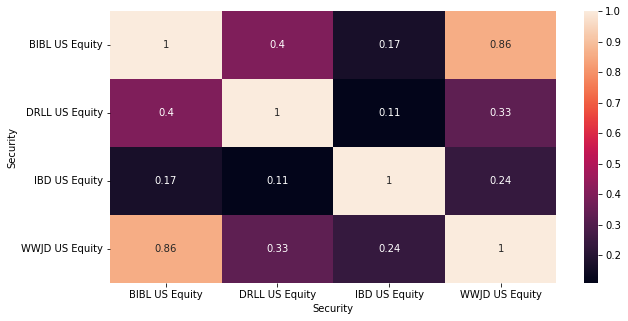

In [69]:
correlation_matrix1 = antiesg_ret.corr()

# Use seaborn to plot the correlation matrix
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix1, annot=True)
plt.show()

#### News Factors

In [70]:
correlation_matrix2 = news_shocks.corr()

# Flatten the correlation matrix and sort to find the top 10 correlations
flattened_corr2 = correlation_matrix2.unstack().sort_values(ascending=False).dropna()

# Exclude self-correlations (correlation of an index with itself)
top_correlations2 = flattened_corr2[flattened_corr2.index.get_level_values(0) != flattened_corr2.index.get_level_values(1)]

# Exclude the even-numbered correlations (which are just the reverse of the odd-numbered correlations)
top_correlations2 = top_correlations2[::2]

# # Get the top 10 correlations
top_20_correlations2 = top_correlations2.head(20)
bottom_20_correlations2 = top_correlations2.tail(20)

# Display the top 10 correlations
print("Top 20 NEWS correlations:")
print(top_20_correlations2)

Top 20 NEWS correlations:
UN/IPCC Reports          cluster_Research               0.930
cluster_Research         Global Warming                 0.916
cluster_Societal Debate  Social Events                  0.915
Aggregate                cluster_Business Impact        0.901
cluster_Societal Debate  Political Campaign             0.897
Aggregate                cluster_Societal Debate        0.897
Agreements/Actions       cluster_Business Impact        0.872
Aggregate                cluster_Environmental Impact   0.869
cluster_Research         Aggregate                      0.848
                         Scientific Studies             0.840
Aggregate                Government Programs            0.831
cluster_Societal Debate  Controversies                  0.829
Social Events            Aggregate                      0.812
Extreme Temperatures     cluster_Environmental Impact   0.812
Government Programs      cluster_Business Impact        0.808
UN/IPCC Reports          Aggregate          

In [71]:
print("Bottom 20 NEWS correlations:")
print(bottom_20_correlations2)

Bottom 20 NEWS correlations:
Airline Industry                 Arctic Wildlife                   0.306
Ecosystems                       Climate Legislation/Regulations   0.305
Arctic Wildlife                  Agriculture Shifts                0.303
Climate Legislation/Regulations  Arctic Wildlife                   0.300
                                 Marine Wildlife                   0.299
Marine Wildlife                  Carbon Credits Market             0.298
Glaciers/Ice Sheets              Carbon Reduction Technologies     0.296
Food Shortage/Poverty            Arctic Wildlife                   0.295
Hurricanes/Floods                Arctic Wildlife                   0.292
Car Industry                     Glaciers/Ice Sheets               0.290
Carbon Tax                       Arctic Wildlife                   0.285
Ecosystems                       Carbon Credits Market             0.280
Marine Wildlife                  Car Industry                      0.279
Glaciers/Ice Sheets   

#### Cross Correlation of Indices against Factors

In [72]:
market_correlations = pd.DataFrame(index=esg_ret_filt.columns, columns=['mkt_correlation'])

for i in range(0, len(esg_ret_filt.columns)):
    correlation_series = esg_ret_filt.iloc[:,i]
    correlation_matrix3 = fama_factors.corrwith(correlation_series)
    market_correlations.loc[esg_ret_filt.columns[i], 'mkt_correlation'] = correlation_matrix3[0]
    
market_correlations.dropna(inplace=True)

# Only keep stocks with a market correlation less than 0.2
market_correlations = market_correlations[market_correlations['mkt_correlation'] < 0.2]
market_correlations

# Keep only the Security in market_correlations
esg_ret_filt_mkt = esg_ret_filt[market_correlations.index]

---

In [73]:
len(esg_ret_filt_mkt.columns)

29

#### Regression of non-US (<0.2 Mkt Beta) ESG Indices against News Factors and Fama French Factors

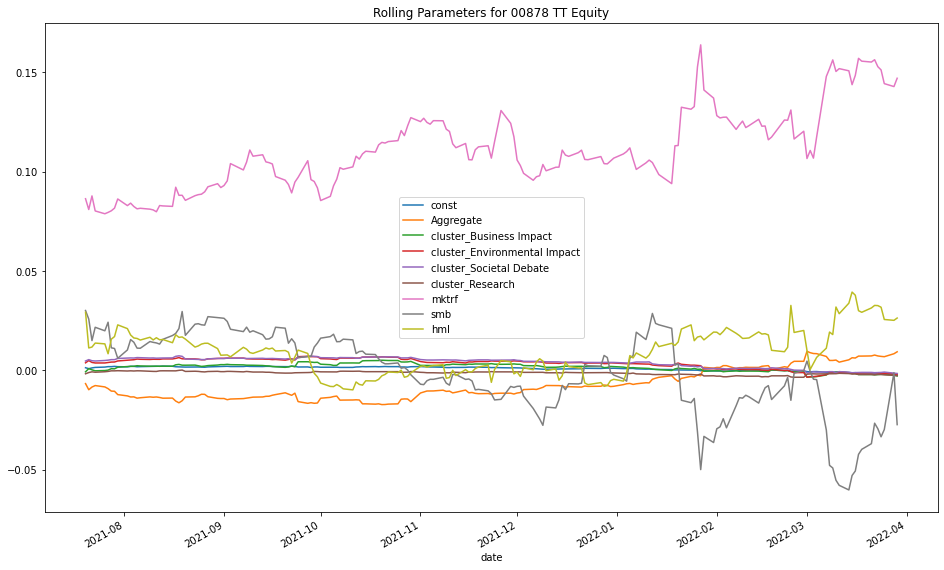

Error in column:  1


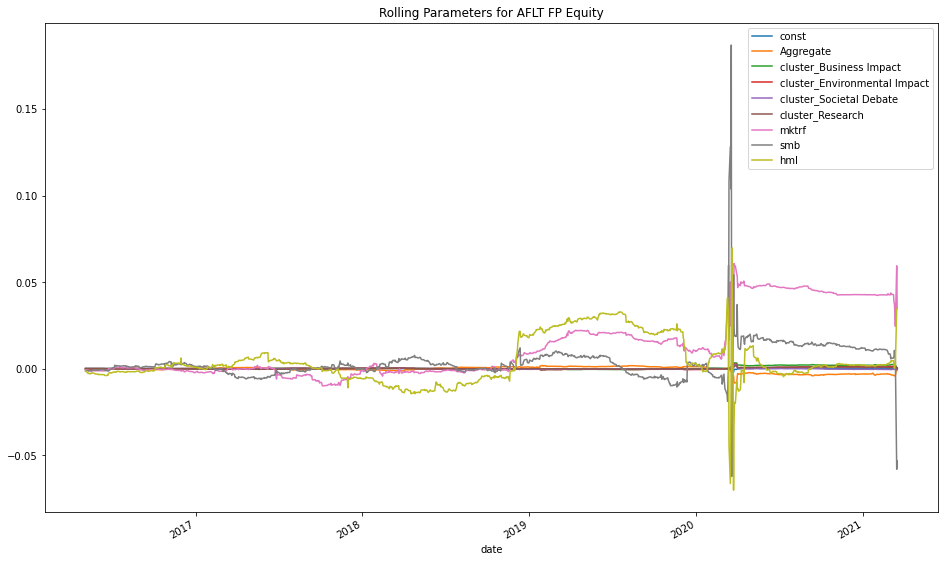

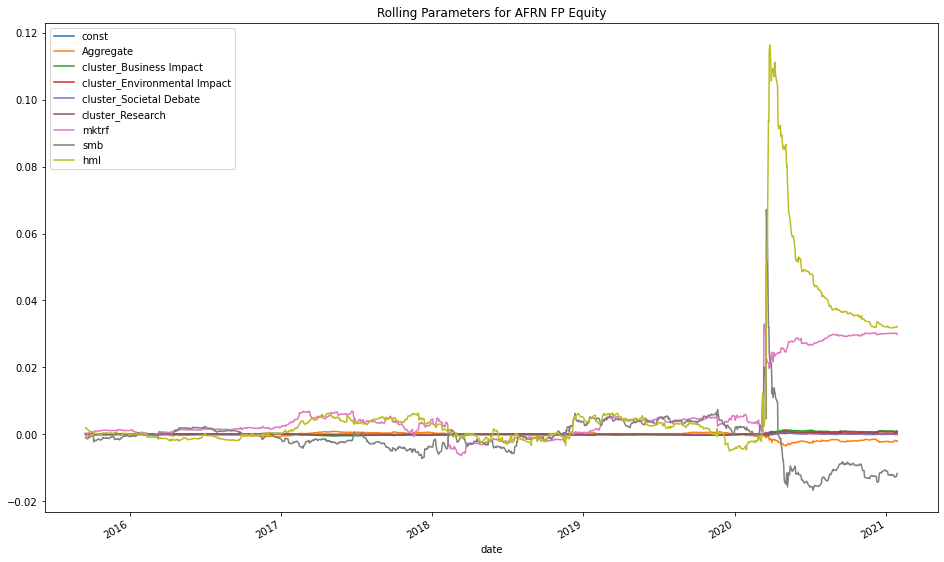

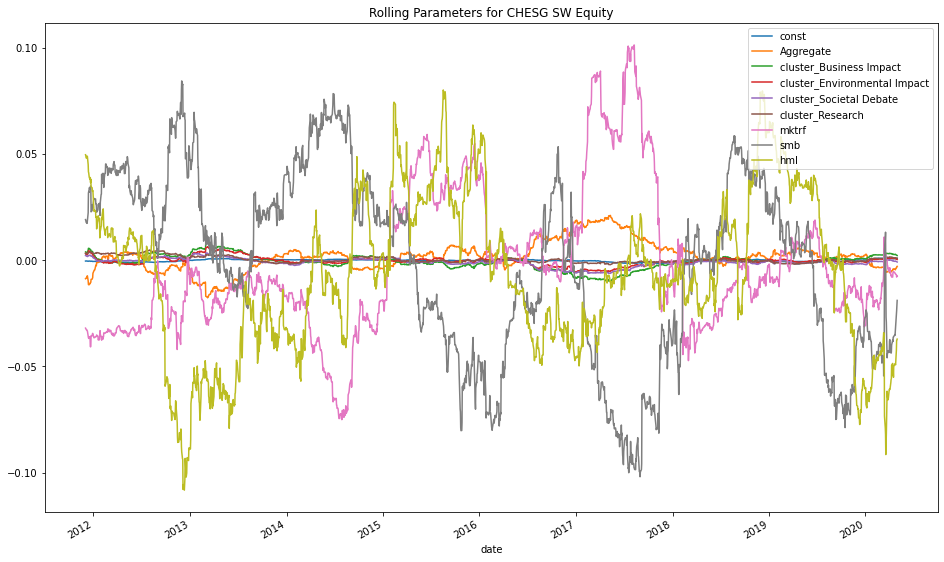

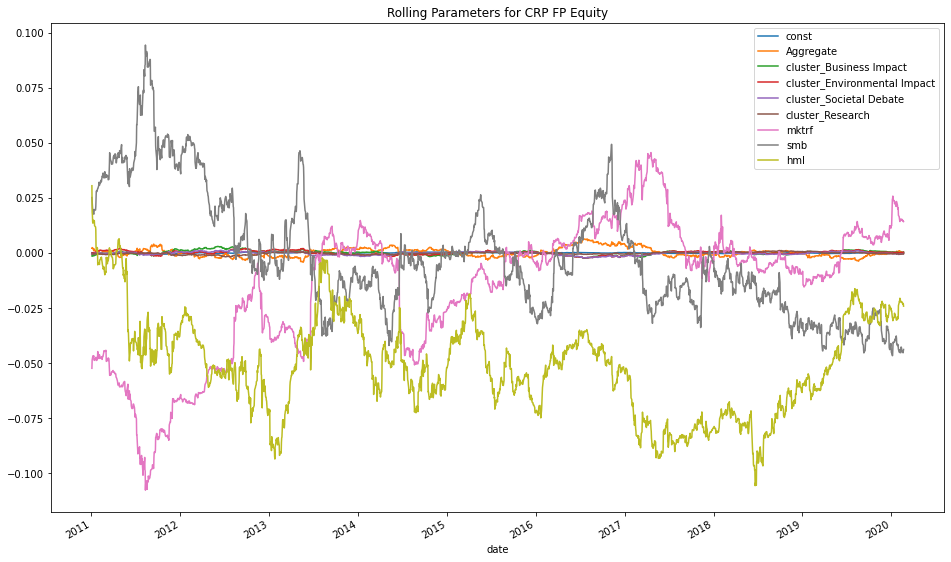

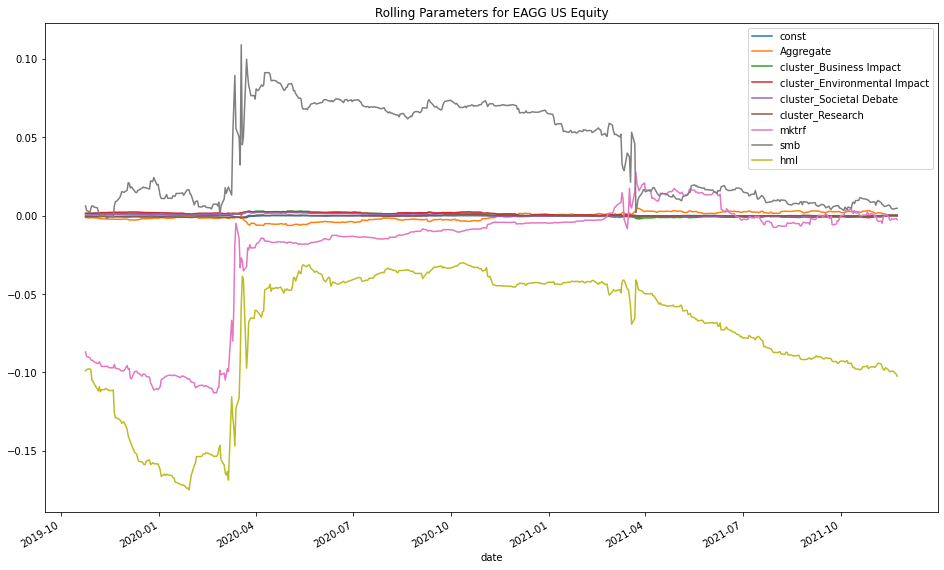

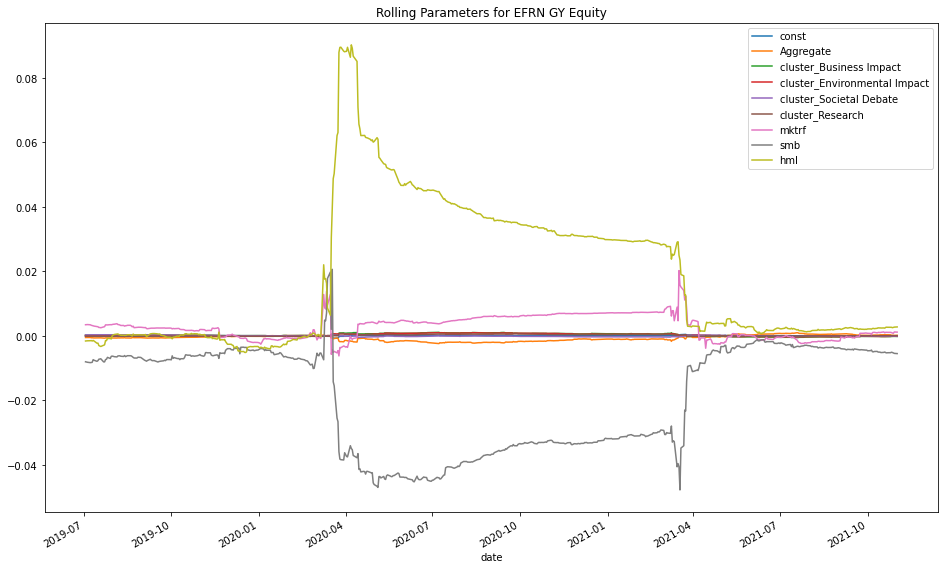

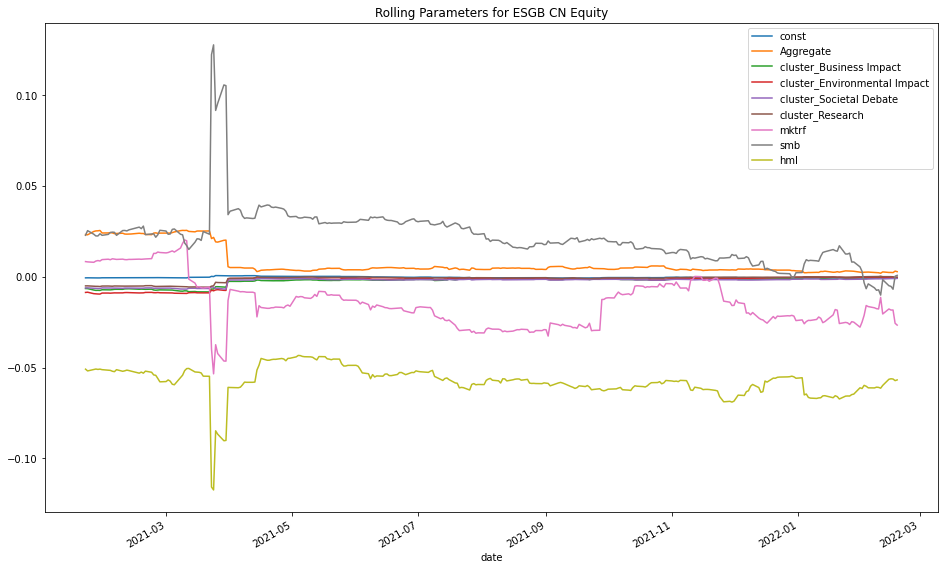

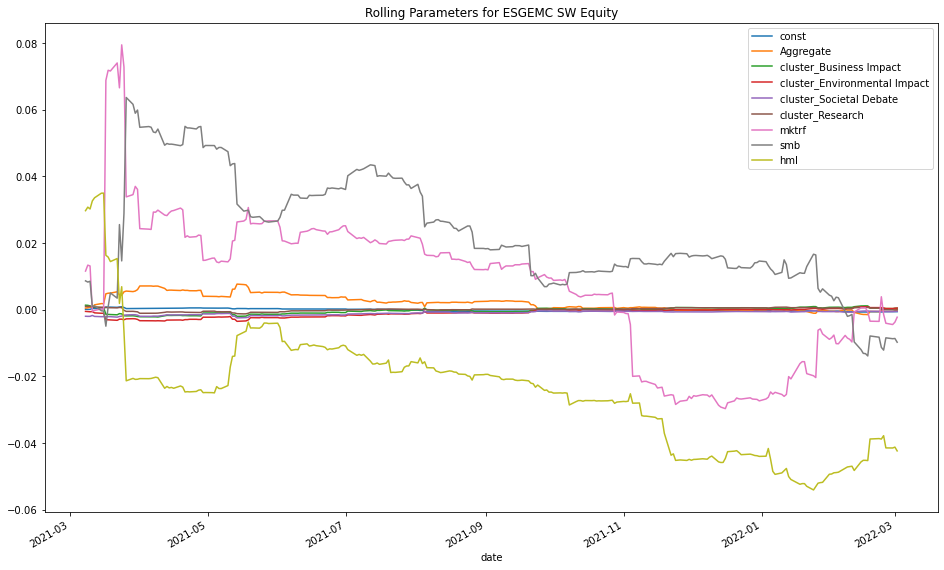

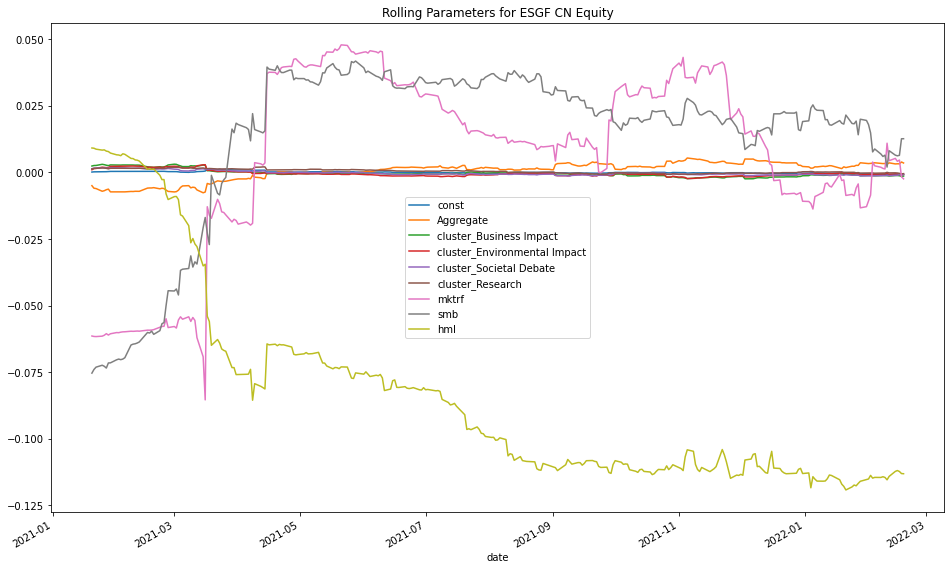

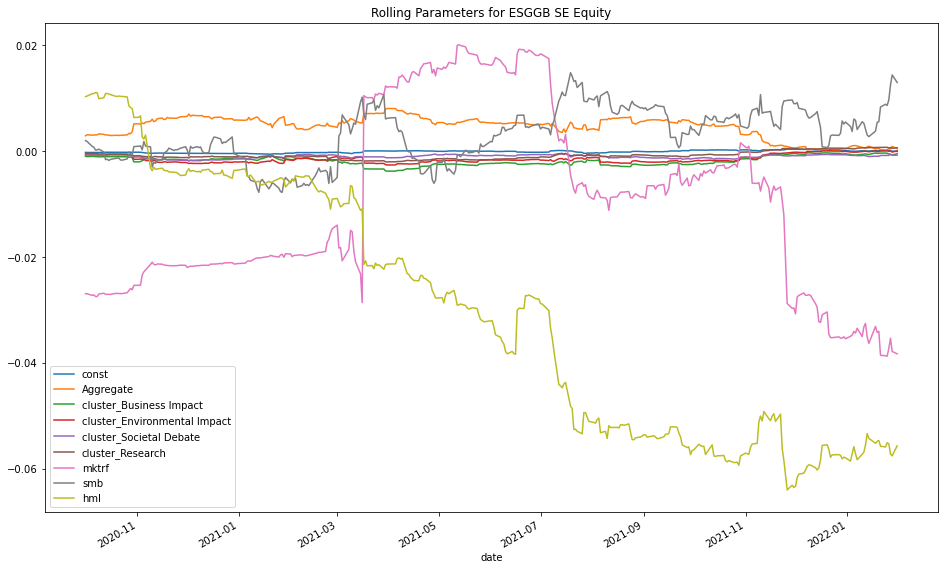

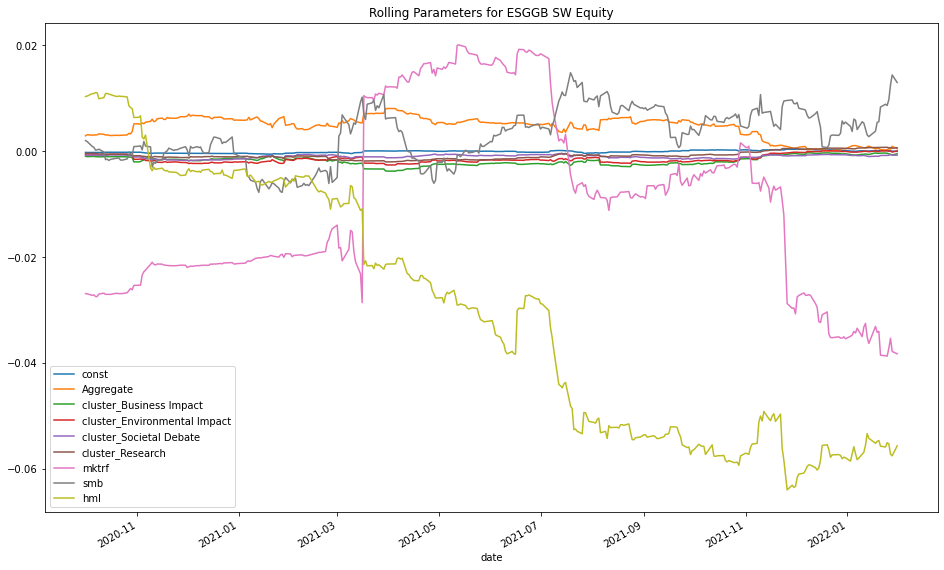

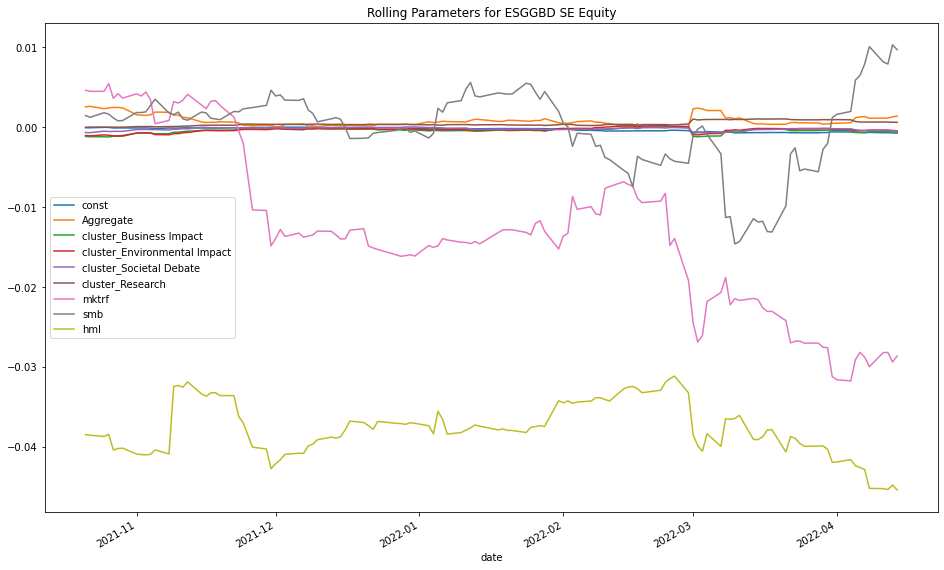

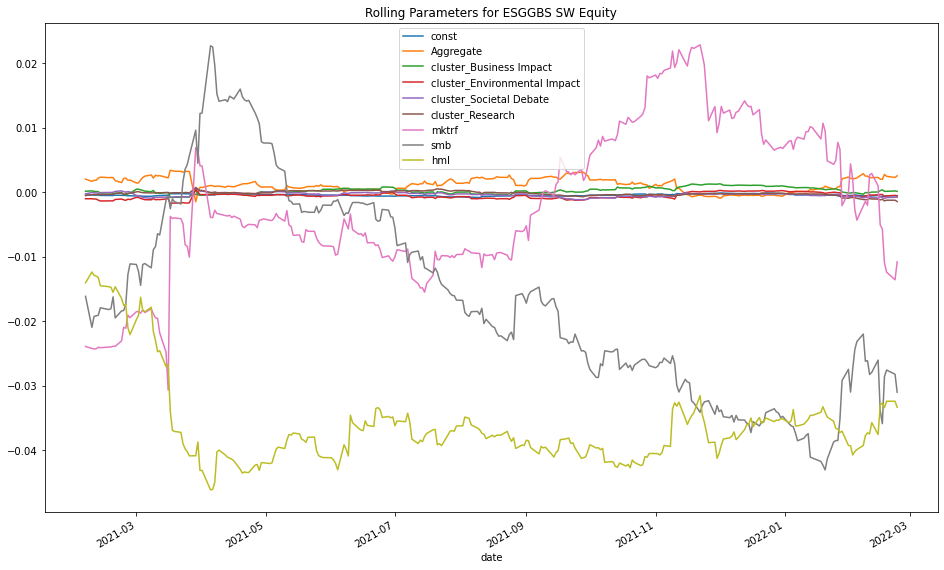

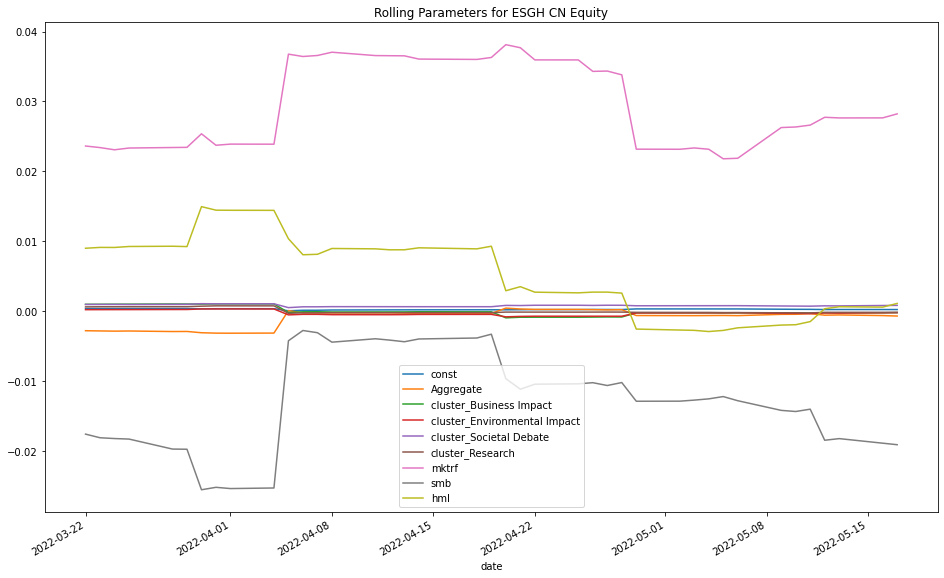

Error in column:  16
Error in column:  17
Error in column:  18
Error in column:  19


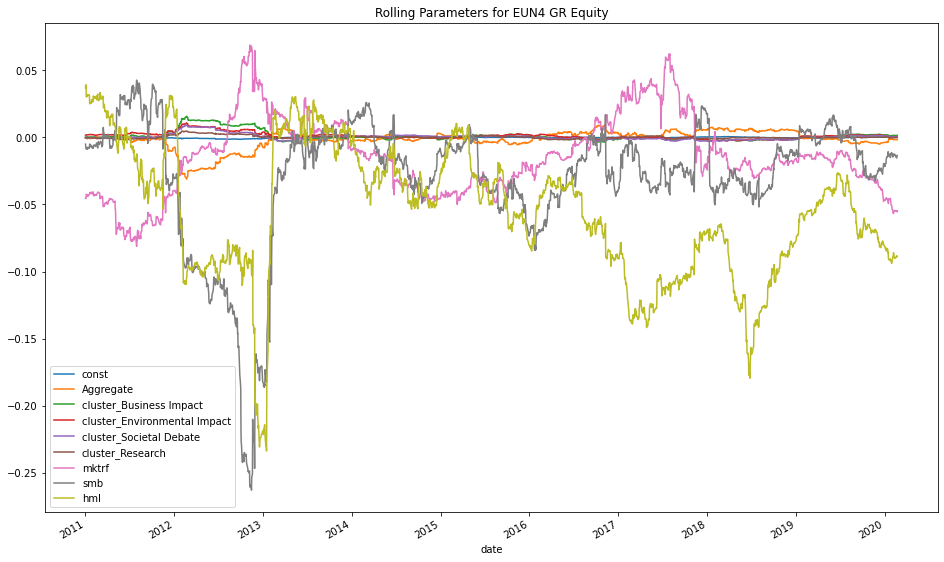

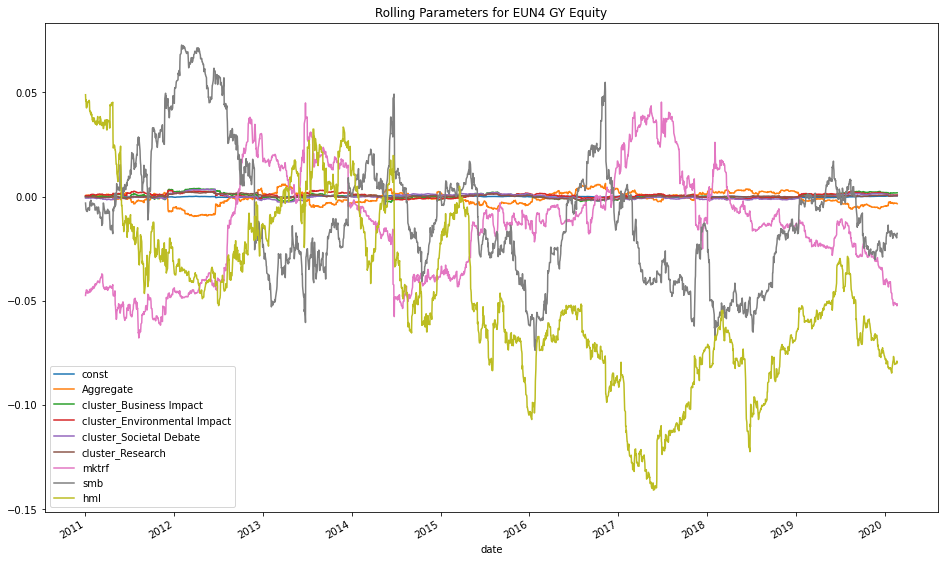

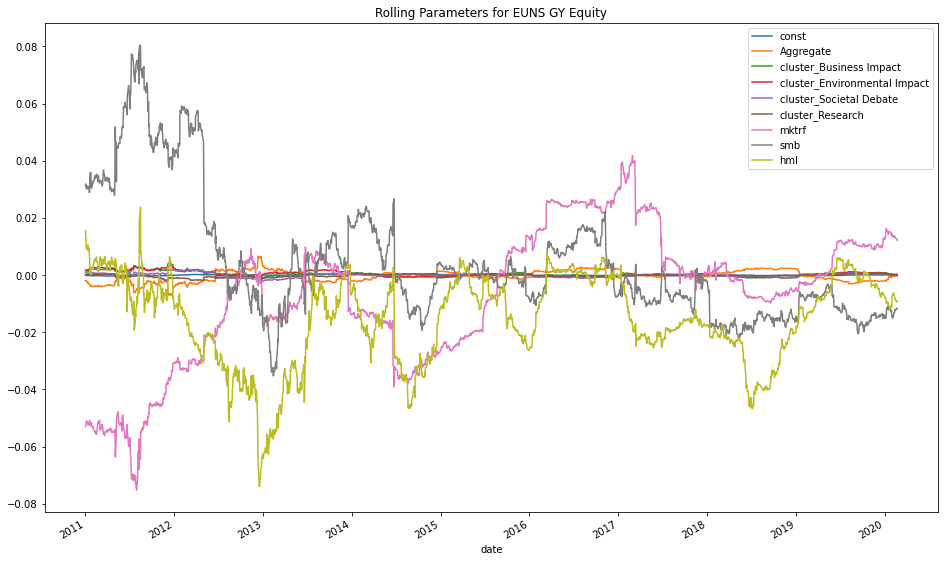

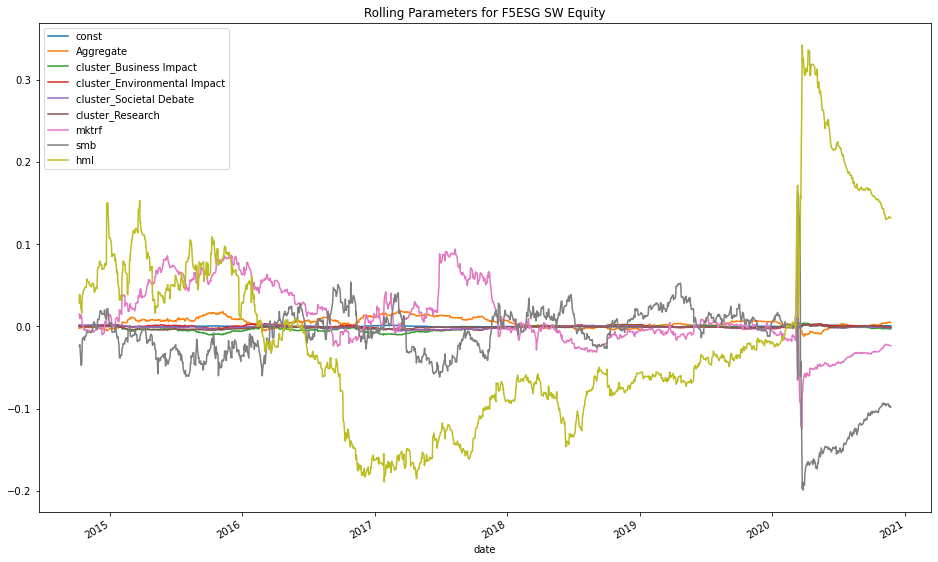

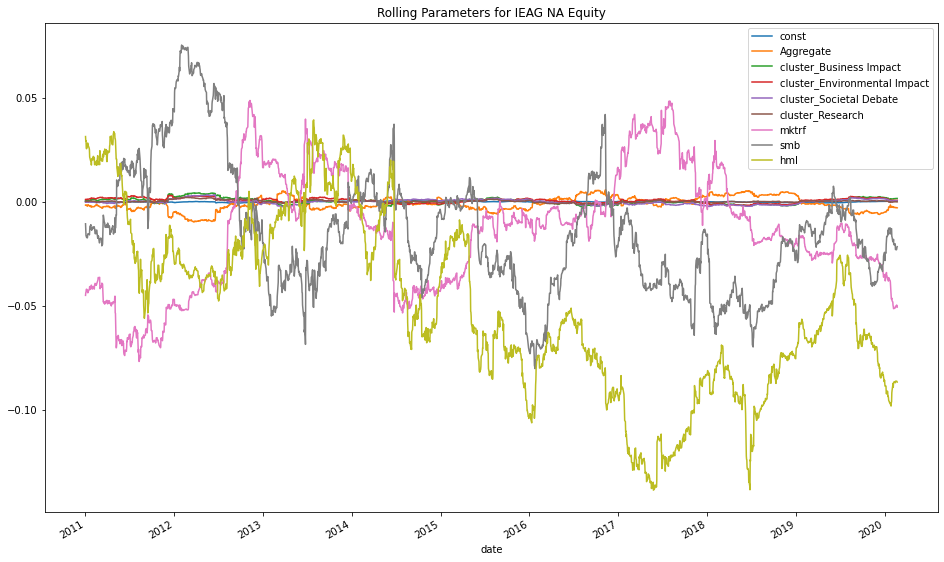

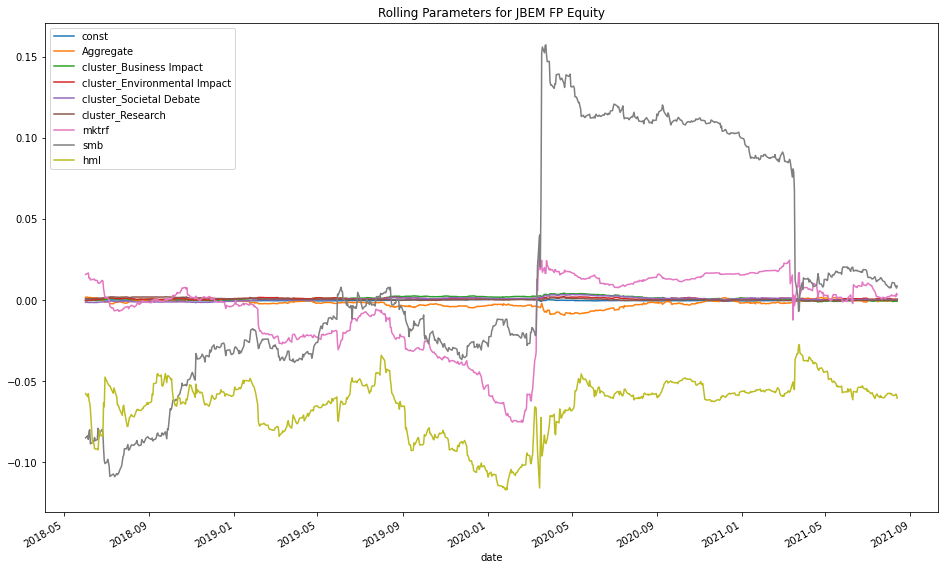

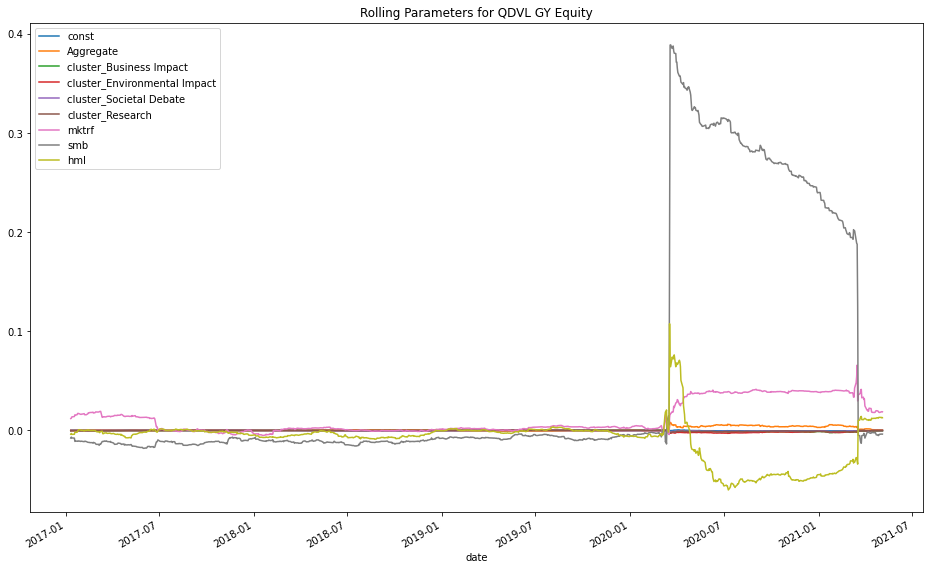

Error in column:  27
Error in column:  28


In [74]:
#Dataframe to store the rolling parameters
rolling_params = pd.DataFrame()
rolling_params.index = esg_ret_filt_mkt.index

for i in range(0, len(esg_ret_filt_mkt.columns)):
    try:    
        esg_temp = esg_ret_filt_mkt.iloc[:,i].dropna()
        
        # Split the esg_temp into train and test sets
        esg_train_temp, esg_test_temp = train_test_split(esg_temp, test_size=0.2, shuffle=False)
        
        # Keep the Aggregate column of news_shocks and all the columns that start with "cluster_"
        news_shocks_temp = news_shocks.loc[:,news_shocks.columns.str.startswith('cluster_') |  news_shocks.columns.str.startswith('Aggregate')].dropna()

        #Create a temporary dataframe with the two series
        temp_df = pd.concat([esg_train_temp, news_shocks_temp], axis=1).dropna()

        # Add fama_factors to the temp_df - only add mktrf, smb, hml
        temp_df = pd.concat([temp_df, fama_factors.loc[:, ['mktrf', 'smb', 'hml']]], axis=1).dropna()

        # Run a rolling regression of esg_temp on news_shocks_temp
        rolling_reg = RollingOLS(temp_df.iloc[:,0], add_constant(temp_df.iloc[:,1:]), window=252)
        rolling_res = rolling_reg.fit()

        # Plot all the parameters
        rolling_res.params.plot(figsize=(16,10))
        plt.title("Rolling Parameters for " + esg_ret_filt_mkt.columns[i])
        plt.show()
        
        # Store the param 1 (slope) in the rolling_params dataframe
        rolling_params[esg_ret_filt_mkt.columns[i]] = rolling_res.params.iloc[:,1]
    except:
        print("Error in column: ", i)

---

#### Regression of non-US (<0.2 Mkt Beta) ESG Indices against News Factors

In [75]:
#Dataframe to store the rolling parameters
rolling_params1 = pd.DataFrame(index=esg_ret_filt_mkt.index)

# Add len(esg_ret_filt_mkt.columns) * 5 columns to the rolling_params1 dataframe
for i in range(0, len(esg_ret_filt_mkt.columns) * 5):
    rolling_params1[i] = np.nan

#Create 5 subcolumns for each column in the rolling_params1 dataframe
rolling_params1.columns = pd.MultiIndex.from_product([esg_ret_filt_mkt.columns, ['const', 'cluster_Business Impact', 'cluster_Environmental Impact', 'cluster_Societal Debate', 'cluster_Research']])

rolling_params1

Security   00878 TT Equity                                          \
                     const cluster_1 cluster_2 cluster_3 cluster_4   
date                                                                 
2010-01-04             NaN       NaN       NaN       NaN       NaN   
2010-01-05             NaN       NaN       NaN       NaN       NaN   
2010-01-06             NaN       NaN       NaN       NaN       NaN   
2010-01-07             NaN       NaN       NaN       NaN       NaN   
2010-01-08             NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...   
2022-08-24             NaN       NaN       NaN       NaN       NaN   
2022-08-25             NaN       NaN       NaN       NaN       NaN   
2022-08-26             NaN       NaN       NaN       NaN       NaN   
2022-08-29             NaN       NaN       NaN       NaN       NaN   
2022-08-30             NaN       NaN       NaN       NaN       NaN   

Security   AEGE GY Equity                                          ...  \
                    const cluster_1 cluster_2 cluster_3 cluster_4  ...   
date                                                               ...   
2010-01-04            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-05            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-06            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-07            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-08            NaN       NaN       NaN       NaN       NaN  ...   
...                   ...       ...       ...       ...       ...  ...   
2022-08-24            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-25            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-26            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-29            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-30            NaN       NaN       NaN       NaN       NaN  ...   

Security   TAEH IM Equity                                          \
                    const cluster_1 cluster_2 cluster_3 cluster_4   
date                                                                
2010-01-04            NaN       NaN       NaN       NaN       NaN   
2010-01-05            NaN       NaN       NaN       NaN       NaN   
2010-01-06            NaN       NaN       NaN       NaN       NaN   
2010-01-07            NaN       NaN       NaN       NaN       NaN   
2010-01-08            NaN       NaN       NaN       NaN       NaN   
...                   ...       ...       ...       ...       ...   
2022-08-24            NaN       NaN       NaN       NaN       NaN   
2022-08-25            NaN       NaN       NaN       NaN       NaN   
2022-08-26            NaN       NaN       NaN       NaN       NaN   
2022-08-29            NaN       NaN       NaN       NaN       NaN   
2022-08-30            NaN       NaN       NaN       NaN       NaN   

Security   TAHY LN Equity                                          
                    const cluster_1 cluster_2 cluster_3 cluster_4  
date                                                               
2010-01-04            NaN       NaN       NaN       NaN       NaN  
2010-01-05            NaN       NaN       NaN       NaN       NaN  
2010-01-06            NaN       NaN       NaN       NaN       NaN  
2010-01-07            NaN       NaN       NaN       NaN       NaN  
2010-01-08            NaN       NaN       NaN       NaN       NaN  
...                   ...       ...       ...       ...       ...  
2022-08-24            NaN       NaN       NaN       NaN       NaN  
2022-08-25            NaN       NaN       NaN       NaN       NaN  
2022-08-26            NaN       NaN       NaN       NaN       NaN  
2022-08-29            NaN       NaN       NaN       NaN       NaN  
2022-08-30            NaN       NaN       NaN       NaN       NaN  

[3274 rows x 145 columns]

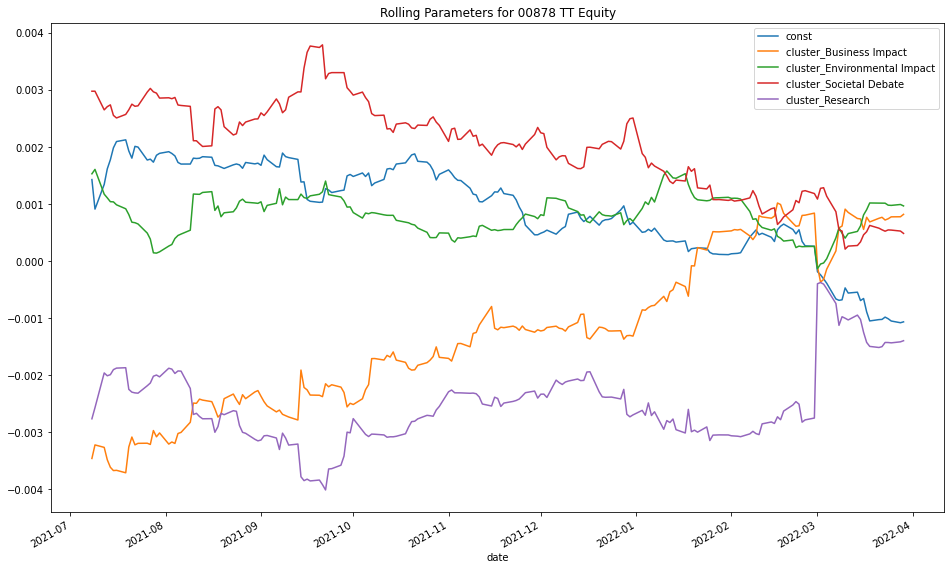

The column AEGE GY Equity does not have enough data.


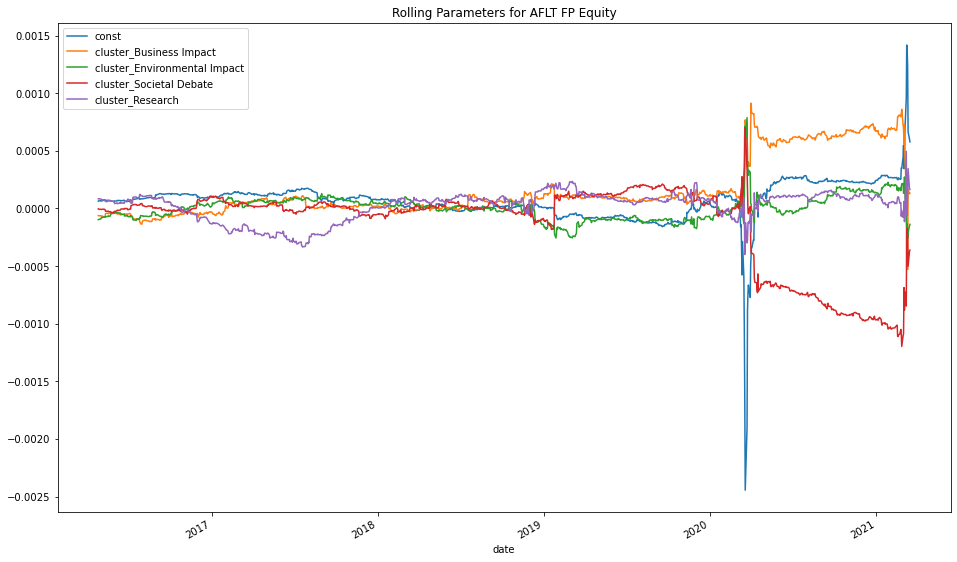

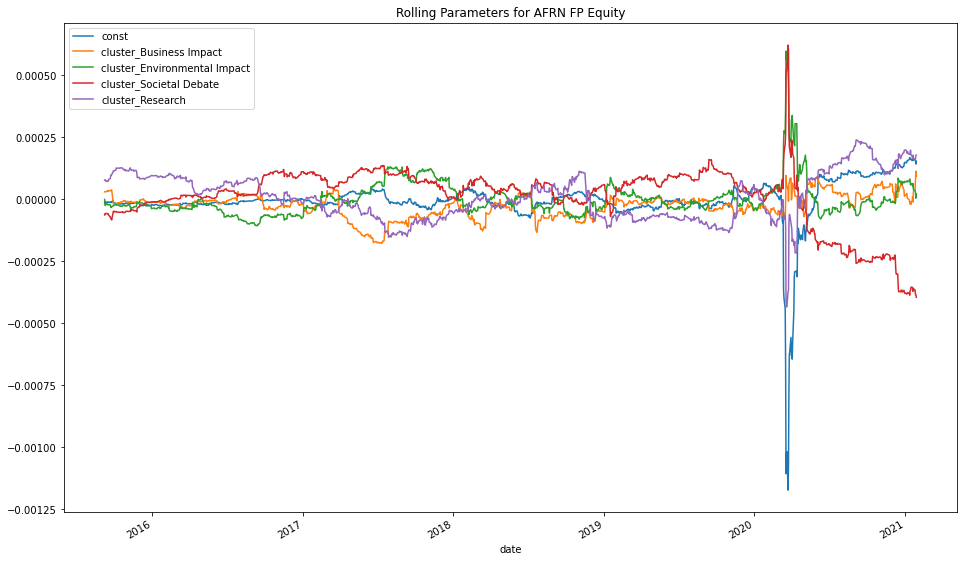

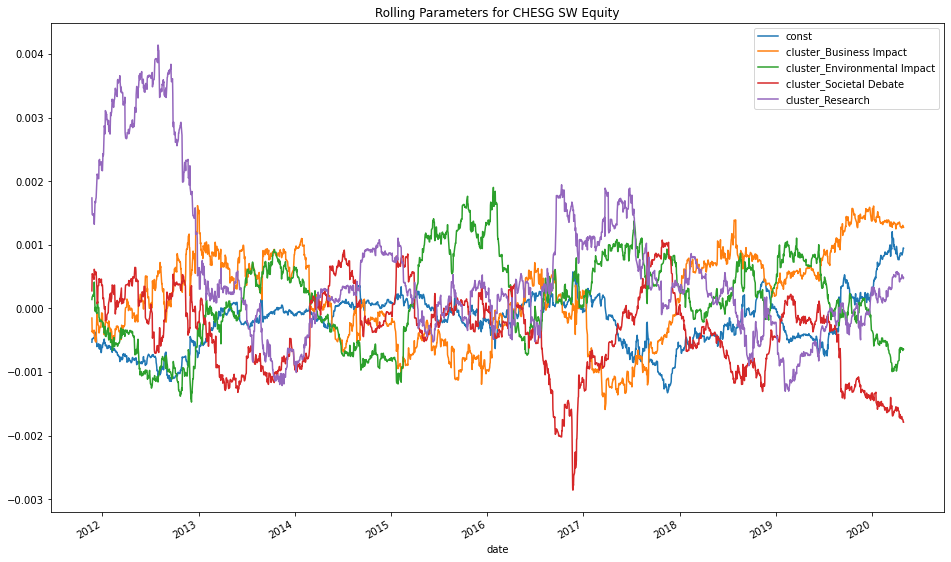

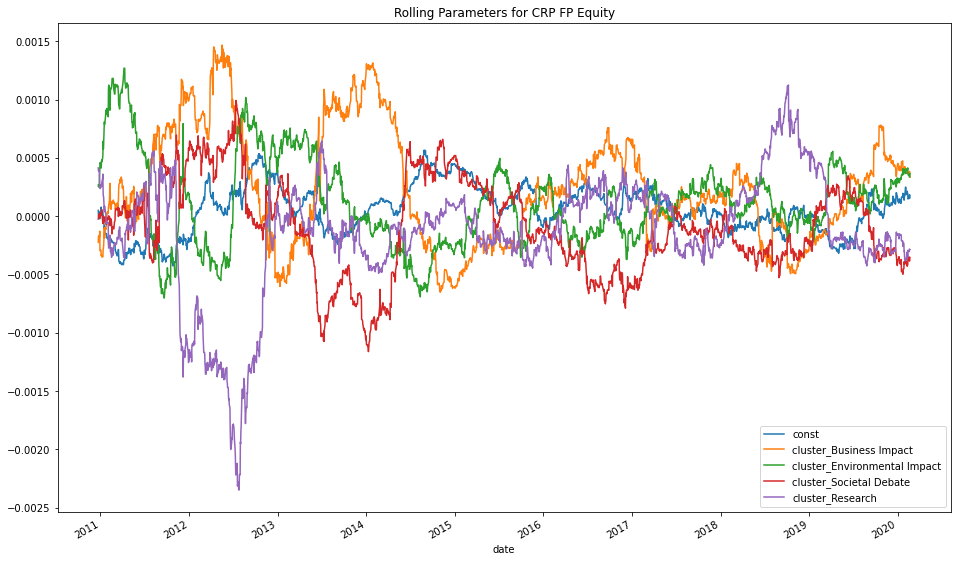

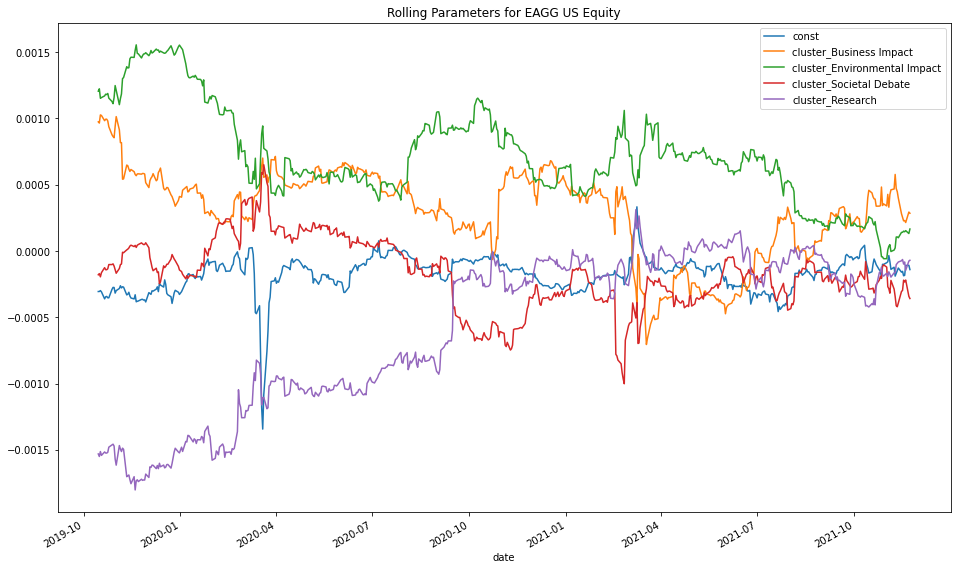

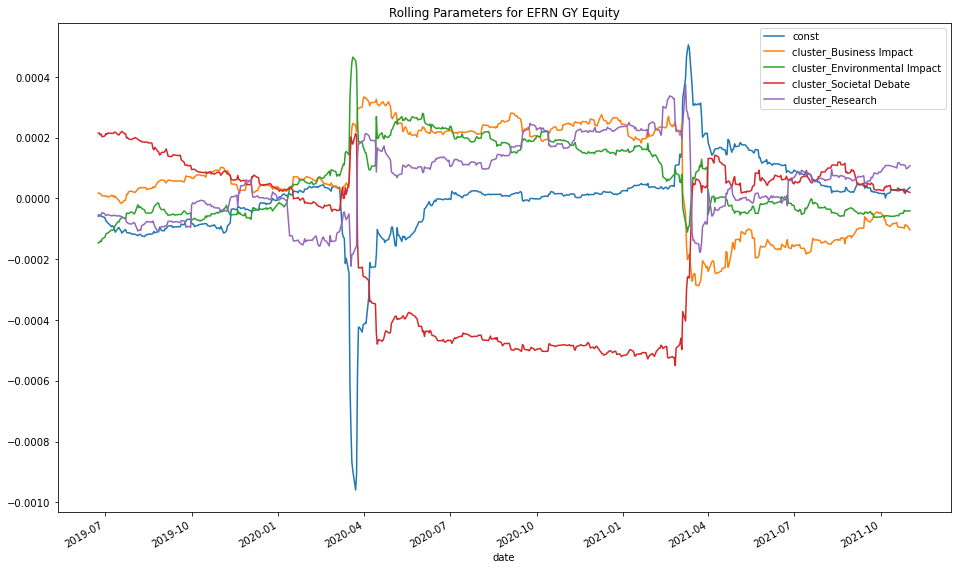

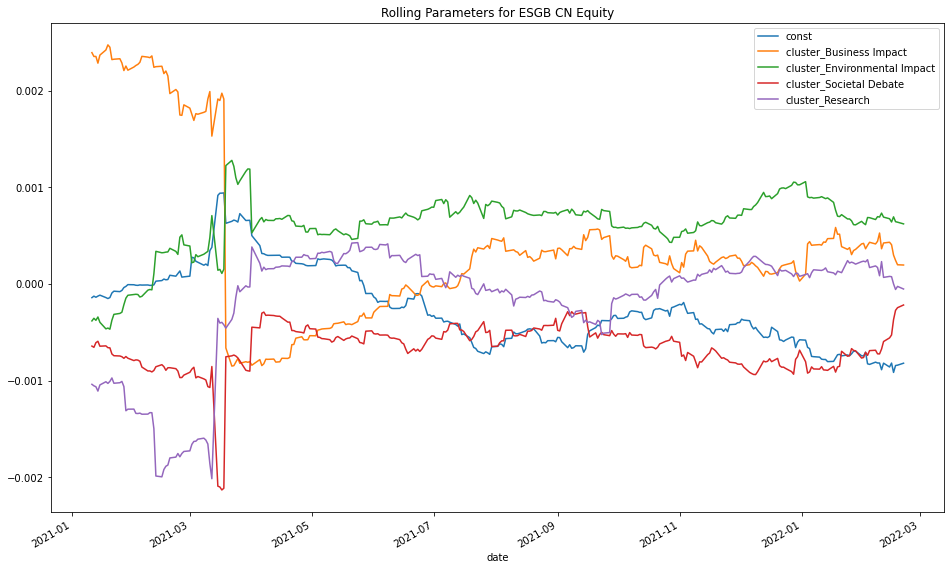

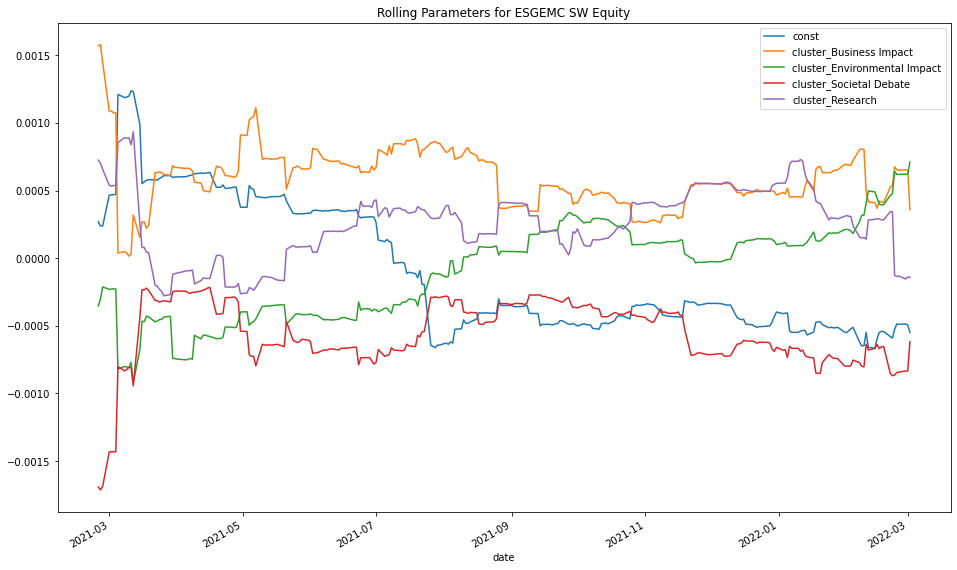

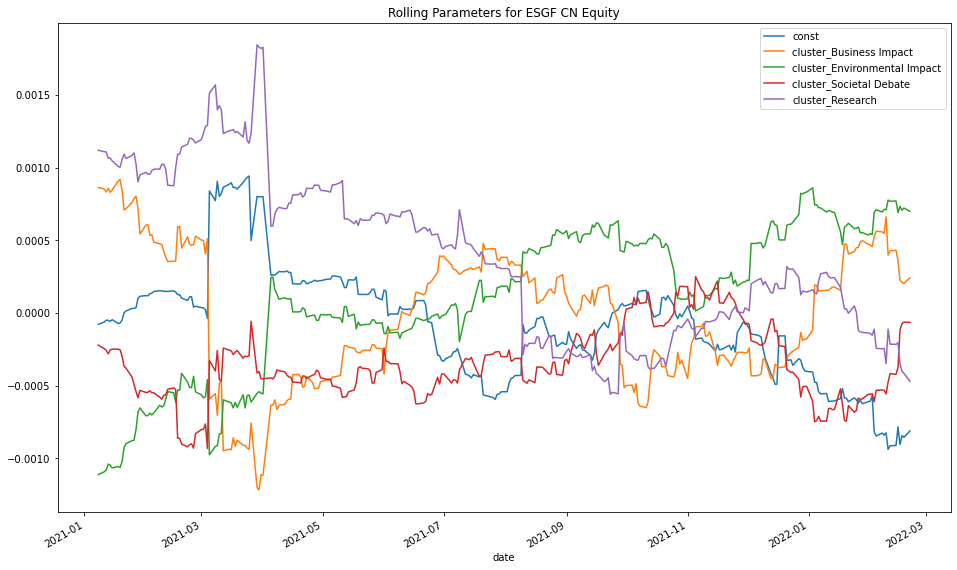

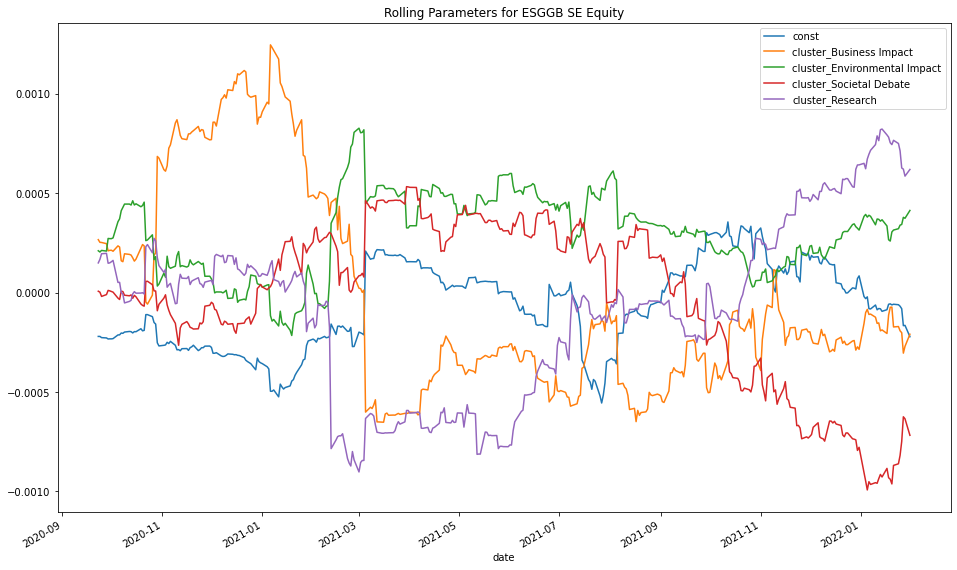

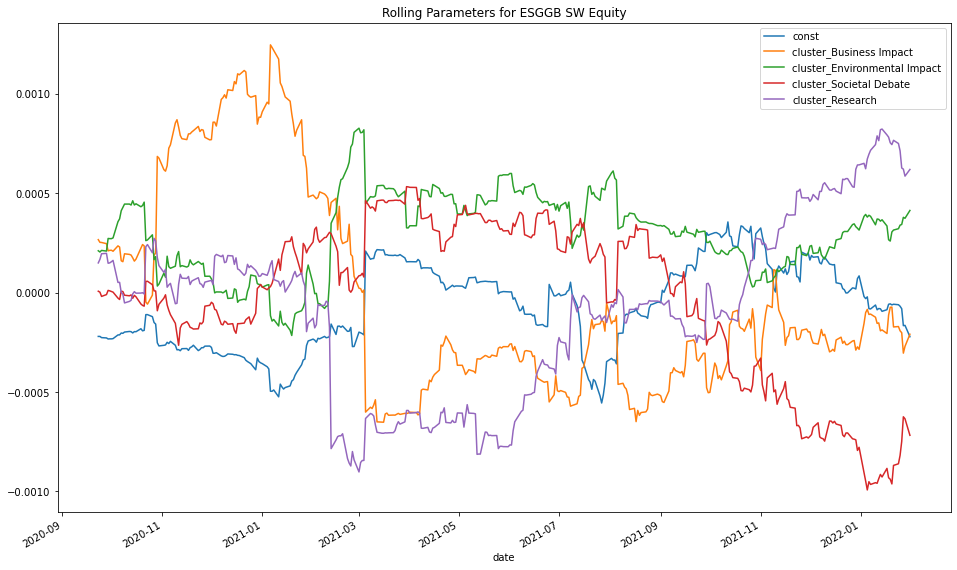

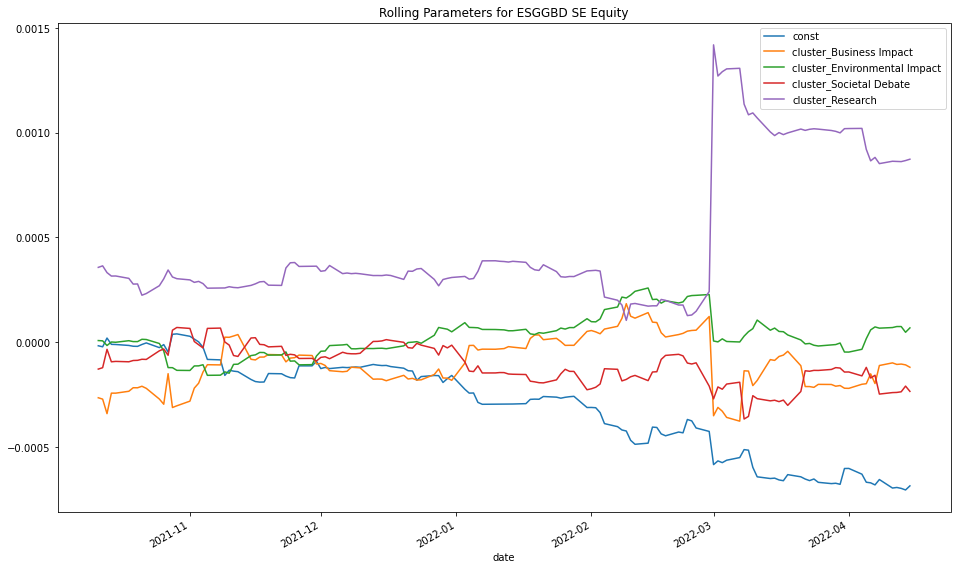

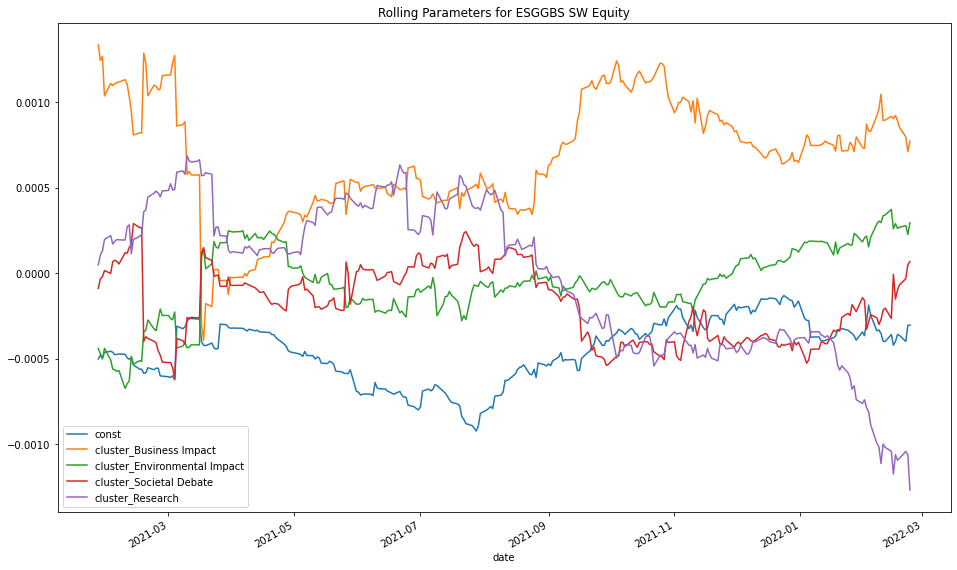

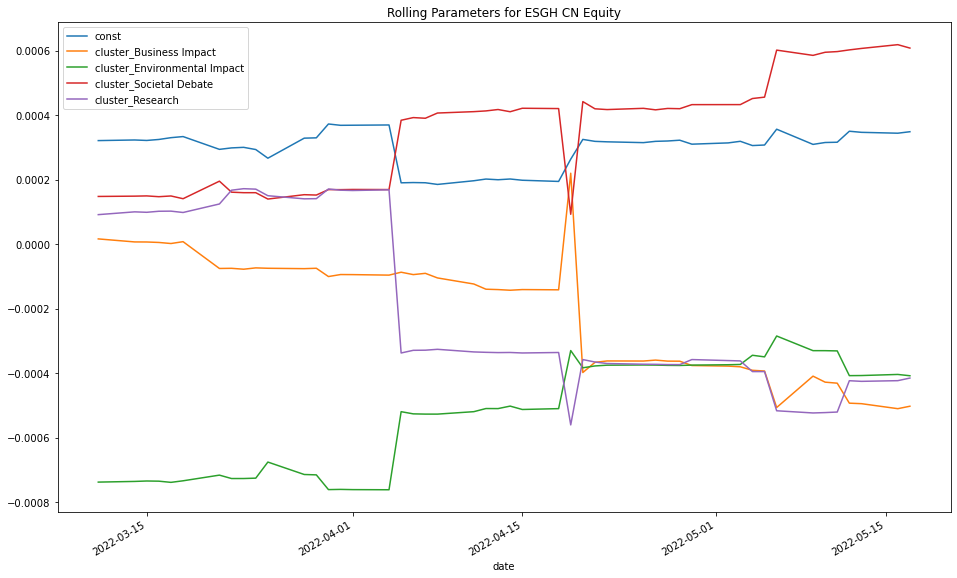

The column ESGO IM Equity does not have enough data.
The column ESGO LN Equity does not have enough data.
The column ESGSG SP Equity does not have enough data.
The column ESGUS SP Equity does not have enough data.


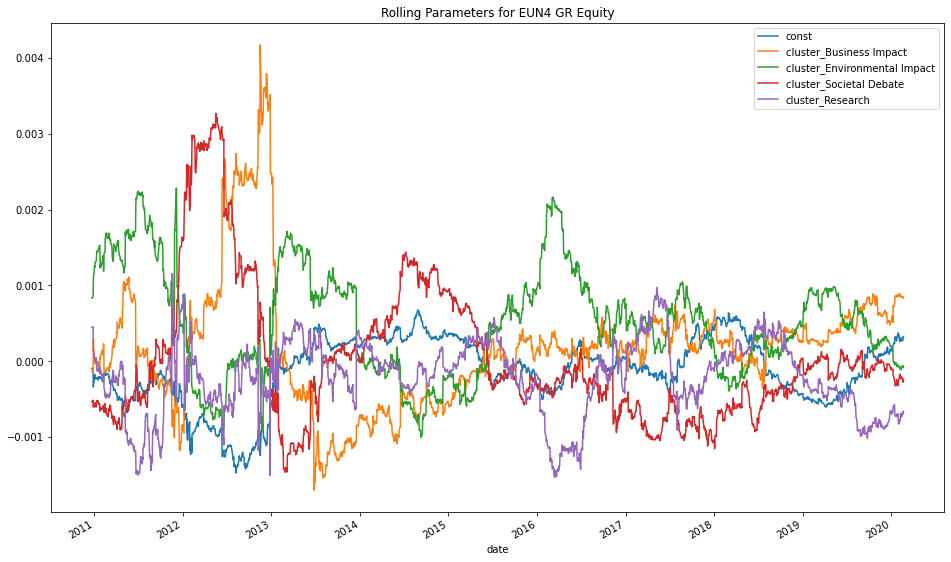

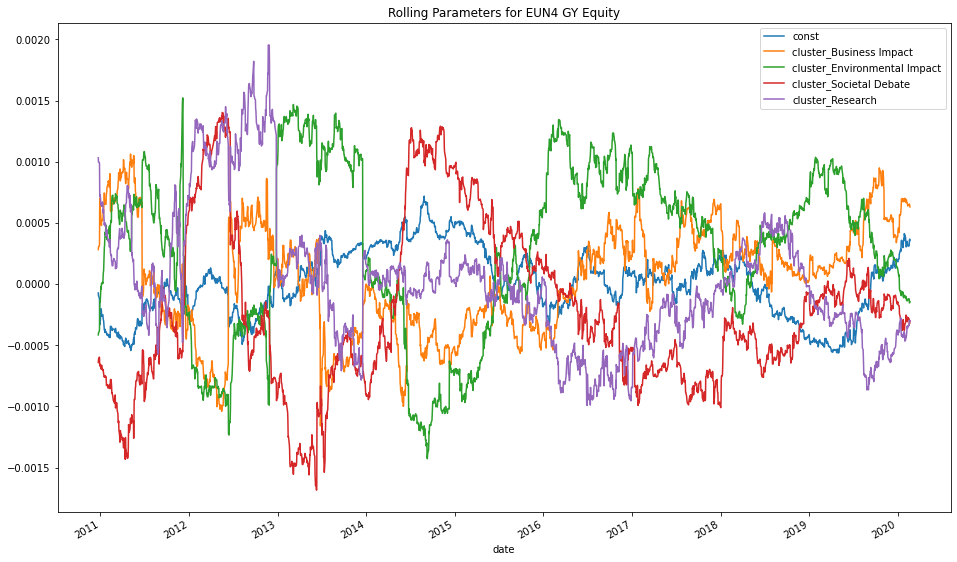

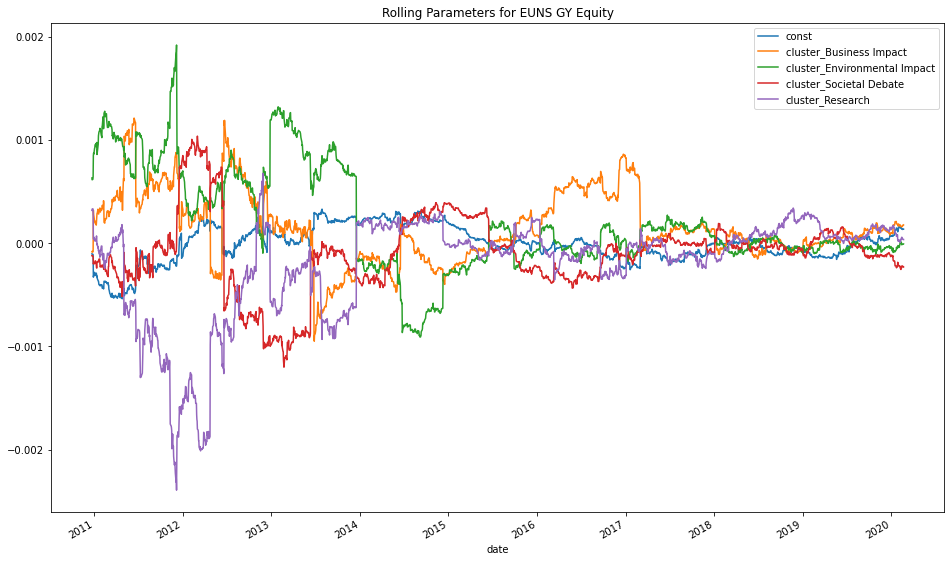

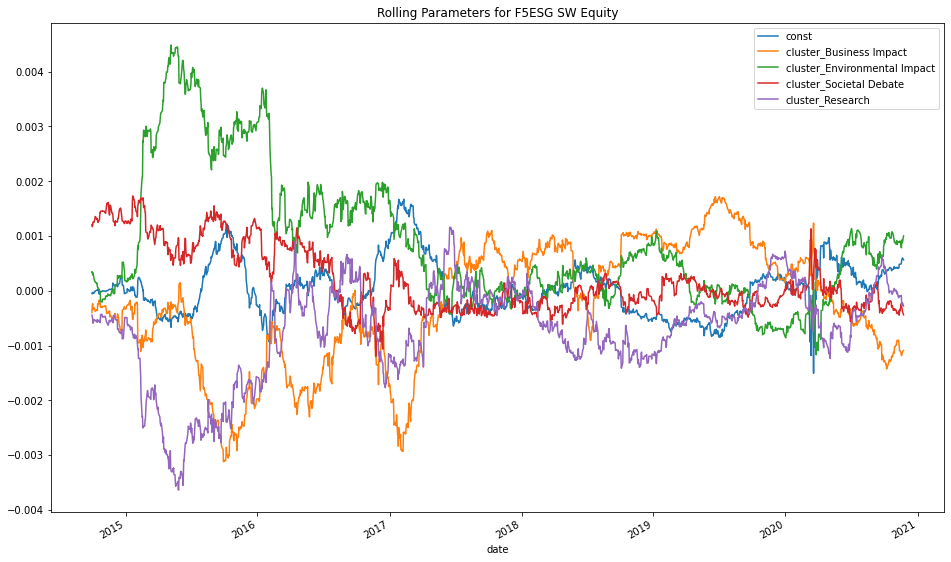

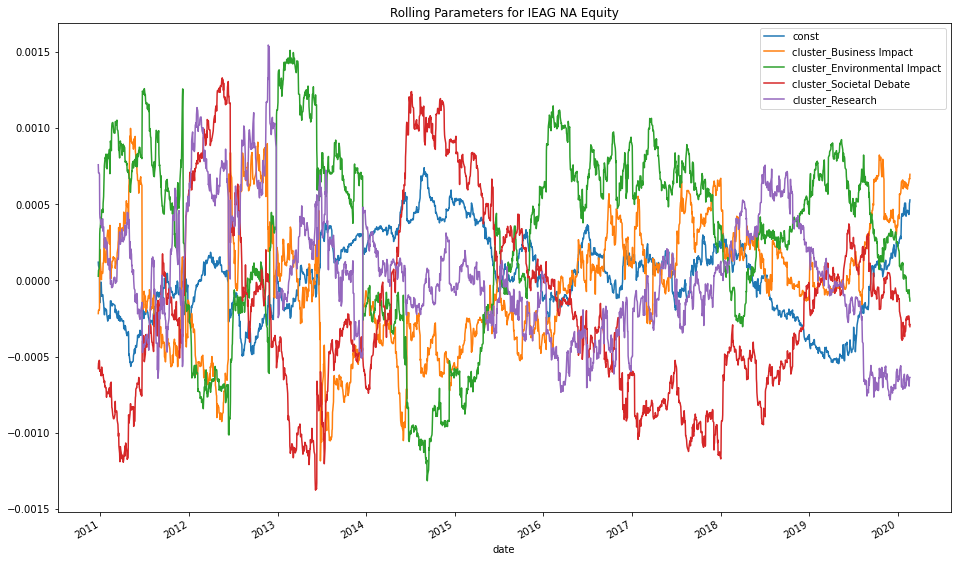

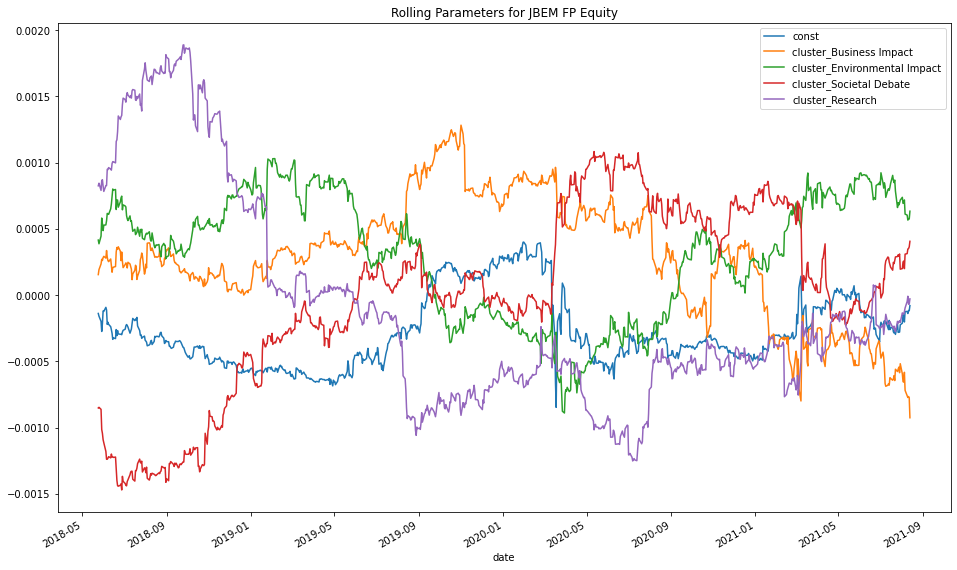

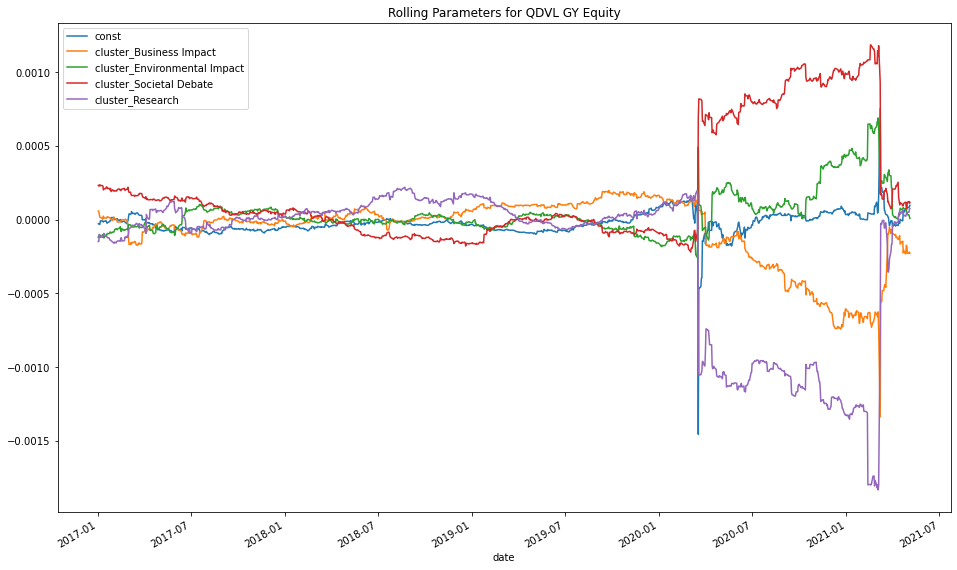

The column TAEH IM Equity does not have enough data.
The column TAHY LN Equity does not have enough data.


In [104]:
#Dataframe to store the rolling parameters
rolling_params1 = pd.DataFrame(index=esg_ret_filt_mkt.index)

# Add len(esg_ret_filt_mkt.columns) * 5 columns to the rolling_params1 dataframe
for i in range(0, len(esg_ret_filt_mkt.columns) * 5):
    rolling_params1[i] = np.nan

#Create 5 subcolumns for each column in the rolling_params1 dataframe
rolling_params1.columns = pd.MultiIndex.from_product([esg_ret_filt_mkt.columns, ['const', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4']])

for i in range(0, len(esg_ret_filt_mkt.columns)):
    try:    
        esg_temp = esg_ret_filt_mkt.iloc[:,i].dropna()
        
        # Split the esg_temp into train and test sets
        esg_train_temp, esg_test_temp = train_test_split(esg_temp, test_size=0.2, shuffle=False)
        
        # Keep the Aggregate column of news_shocks and all the columns that start with "cluster_"
        news_shocks_temp = news_shocks.loc[:,news_shocks.columns.str.startswith('cluster_')].dropna()
        
        # # Take the returns of the clusters
        # news_shocks_temp = news_shocks_temp.pct_change()

        # # Replace -inf and inf with NaN
        # news_shocks_temp = news_shocks_temp.replace([np.inf, -np.inf], np.nan)
        
        # # Drop nan values
        # news_shocks_temp = news_shocks_temp.dropna()

        #Create a temporary dataframe with the two series
        temp_df = pd.concat([esg_train_temp, news_shocks_temp], axis=1).dropna()

        # Add fama_factors to the temp_df - only add mktrf, smb, hml
        #temp_df = pd.concat([temp_df, fama_factors.loc[:, ['mktrf', 'smb', 'hml']]], axis=1).dropna()

        # Run a rolling regression of esg_temp on news_shocks_temp
        rolling_reg = RollingOLS(temp_df.iloc[:,0], add_constant(temp_df.iloc[:,1:]), window=252)
        rolling_res = rolling_reg.fit()

        # Plot all the parameters
        rolling_res.params.plot(figsize=(16,10))
        plt.title("Rolling Parameters for " + esg_ret_filt_mkt.columns[i])
        plt.show()
        
        # Store all the parameters using multi-indexing on the rolling_params1 dataframe
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'const')] = rolling_res.params.iloc[:,0]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_1')] = rolling_res.params.iloc[:,1]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_2')] = rolling_res.params.iloc[:,2]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_3')] = rolling_res.params.iloc[:,3]
        rolling_params1.loc[:,(esg_ret_filt_mkt.columns[i], 'cluster_4')] = rolling_res.params.iloc[:,4]
        
    except:
        print("The column " + esg_ret_filt_mkt.columns[i] + " does not have enough data.")

In [80]:
rolling_params1

Security   00878 TT Equity                                          \
                     const cluster_1 cluster_2 cluster_3 cluster_4   
date                                                                 
2010-01-04             NaN       NaN       NaN       NaN       NaN   
2010-01-05             NaN       NaN       NaN       NaN       NaN   
2010-01-06             NaN       NaN       NaN       NaN       NaN   
2010-01-07             NaN       NaN       NaN       NaN       NaN   
2010-01-08             NaN       NaN       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...   
2022-08-24             NaN       NaN       NaN       NaN       NaN   
2022-08-25             NaN       NaN       NaN       NaN       NaN   
2022-08-26             NaN       NaN       NaN       NaN       NaN   
2022-08-29             NaN       NaN       NaN       NaN       NaN   
2022-08-30             NaN       NaN       NaN       NaN       NaN   

Security   AEGE GY Equity                                          ...  \
                    const cluster_1 cluster_2 cluster_3 cluster_4  ...   
date                                                               ...   
2010-01-04            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-05            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-06            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-07            NaN       NaN       NaN       NaN       NaN  ...   
2010-01-08            NaN       NaN       NaN       NaN       NaN  ...   
...                   ...       ...       ...       ...       ...  ...   
2022-08-24            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-25            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-26            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-29            NaN       NaN       NaN       NaN       NaN  ...   
2022-08-30            NaN       NaN       NaN       NaN       NaN  ...   

Security   TAEH IM Equity                                          \
                    const cluster_1 cluster_2 cluster_3 cluster_4   
date                                                                
2010-01-04            NaN       NaN       NaN       NaN       NaN   
2010-01-05            NaN       NaN       NaN       NaN       NaN   
2010-01-06            NaN       NaN       NaN       NaN       NaN   
2010-01-07            NaN       NaN       NaN       NaN       NaN   
2010-01-08            NaN       NaN       NaN       NaN       NaN   
...                   ...       ...       ...       ...       ...   
2022-08-24            NaN       NaN       NaN       NaN       NaN   
2022-08-25            NaN       NaN       NaN       NaN       NaN   
2022-08-26            NaN       NaN       NaN       NaN       NaN   
2022-08-29            NaN       NaN       NaN       NaN       NaN   
2022-08-30            NaN       NaN       NaN       NaN       NaN   

Security   TAHY LN Equity                                          
                    const cluster_1 cluster_2 cluster_3 cluster_4  
date                                                               
2010-01-04            NaN       NaN       NaN       NaN       NaN  
2010-01-05            NaN       NaN       NaN       NaN       NaN  
2010-01-06            NaN       NaN       NaN       NaN       NaN  
2010-01-07            NaN       NaN       NaN       NaN       NaN  
2010-01-08            NaN       NaN       NaN       NaN       NaN  
...                   ...       ...       ...       ...       ...  
2022-08-24            NaN       NaN       NaN       NaN       NaN  
2022-08-25            NaN       NaN       NaN       NaN       NaN  
2022-08-26            NaN       NaN       NaN       NaN       NaN  
2022-08-29            NaN       NaN       NaN       NaN       NaN  
2022-08-30            NaN       NaN       NaN       NaN       NaN  

[3274 rows x 145 columns]

In [137]:
#Generate trading signals on the rolling_params1_1 dataframe to trade the first stock in the esg_ret_filt_mkt dataframe and backtest
def generate_trading_signals(rolling_params1_1):
    # Drop all nan values
    rolling_params1_1_temp = rolling_params1_1.dropna()
    
    # Create a dataframe to store the trading signals
    trading_signals = pd.DataFrame(index=rolling_params1_1_temp.index)
    trading_signals['signal'] = 0.0
    
    # Find the cluster with the highest average beta by taking the absolute value of the rolling_params1_1_temp dataframe and finding the column with the highest average
    cluster = abs(rolling_params1_1_temp).mean().idxmax()
    #abs(rolling_params1_1.iloc[:,1:5].mean(axis=0)).idxmax()
    
    # Generate the trading signals based on the cluster with the highest average beta
    # Check if cluster mean is positive or negative
    if rolling_params1_1_temp[cluster].mean() > 0:
        trading_signals['signal'] = np.where(rolling_params1_1_temp[cluster] > 0, 1.0, -1.0)
    else:
        trading_signals['signal'] = np.where(rolling_params1_1_temp[cluster] > 0, -1.0, 1.0)
    # trading_signals['positions'] = trading_signals['signal'].diff()
    
    # Shift the trading signals by 1 day
    trading_signals['signal'] = trading_signals['signal'].shift(-1)
    
    #Print the name of the cluster with the highest average beta
    print("The cluster with the highest average beta is: ", cluster)
    
    return trading_signals


# Backtest the trading signals and calculate potential cumulative returns
def backtest(trading_signals, esg_ret_filt_mkt, number):
    # Drop all nan values
    esg_ret_filt_mkt_temp = esg_ret_filt_mkt.iloc[:,number].dropna()
    
    # Create a dataframe to store the strategy returns
    strategy_returns = pd.DataFrame(index=trading_signals.index)
    strategy_returns['returns'] = trading_signals['signal'] * esg_ret_filt_mkt_temp
    strategy_returns['returns'] = strategy_returns['returns'].dropna()
    strategy_returns['returns'] = strategy_returns['returns'].cumsum()
    return strategy_returns



# Plot a cumulative returns graph
def plot_cumulative_returns(strategy_returns):
    # Plot the cumulative returns
    strategy_returns.plot(figsize=(16,10))
    plt.title("Cumulative Returns")
    plt.show()
    
    # Calculate the Sharpe ratio
    sharpe_ratio = strategy_returns['returns'].mean() / strategy_returns['returns'].std()
    print("Sharpe Ratio: ", sharpe_ratio)
    
    # Calculate the annualized Sharpe ratio
    annualized_sharpe_ratio = (252**0.5) * sharpe_ratio
    print("Annualized Sharpe Ratio: ", annualized_sharpe_ratio)
    
    # Calculate the maximum drawdown
    strategy_returns['cum_returns'] = strategy_returns['returns'].cummax()
    strategy_returns['drawdown'] = strategy_returns['cum_returns'] - strategy_returns['returns']
    max_drawdown = strategy_returns['drawdown'].max()
    print("Maximum Drawdown: ", max_drawdown)
    
    # Calculate the annualized return
    annualized_return = strategy_returns['returns'].mean() * 252
    print("Annualized Return: ", annualized_return)
    
    # Calculate the annualized volatility
    annualized_volatility = strategy_returns['returns'].std() * (252**0.5)
    print("Annualized Volatility: ", annualized_volatility)
    
    # Calculate the Sortino ratio
    sortino_ratio = strategy_returns['returns'].mean() / strategy_returns['returns'][strategy_returns['returns'] < 0].std()
    print("Sortino Ratio: ", sortino_ratio)
    
    # Calculate the annualized Sortino ratio
    annualized_sortino_ratio = (252**0.5) * sortino_ratio
    print("Annualized Sortino Ratio: ", annualized_sortino_ratio)
    
    # Calculate the Calmar ratio
    calmar_ratio = annualized_return / max_drawdown
    print("Calmar Ratio: ", calmar_ratio)
    
    # Calculate the Omega ratio
    omega_ratio = strategy_returns['returns'][strategy_returns['returns'] > 0].sum() / abs(strategy_returns['returns'][strategy_returns['returns'] < 0].sum())
    print("Omega Ratio: ", omega_ratio)
    
    # Calculate the Skewness
    skewness = strategy_returns['returns'].skew()
    print("Skewness: ", skewness)
    
    return strategy_returns


The cluster with the highest average beta is:  ('00878 TT Equity', 'cluster_4')


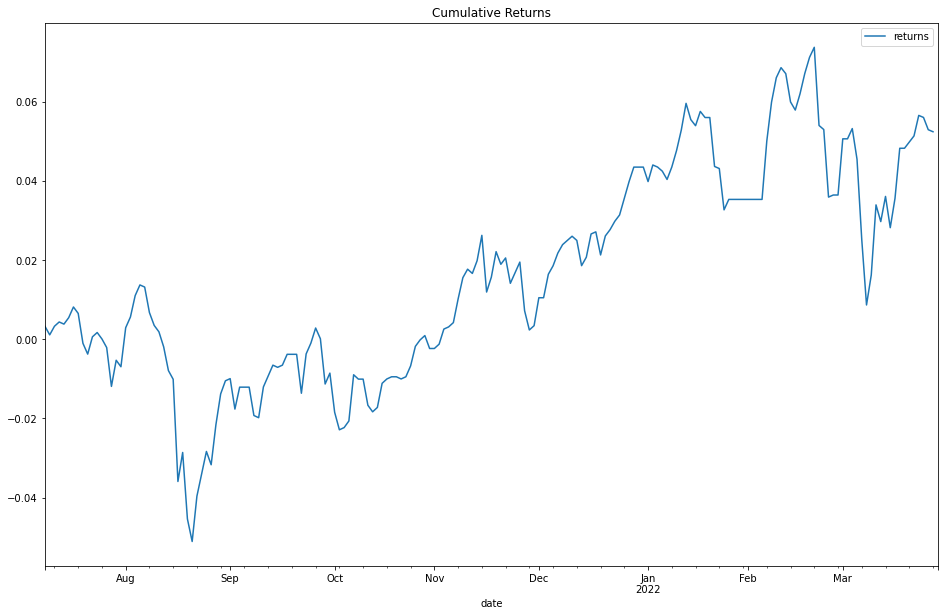

Sharpe Ratio:  0.5882975119056115
Annualized Sharpe Ratio:  9.33893348052185
Maximum Drawdown:  0.0650977287458836
Annualized Return:  4.0188611099530585
Annualized Volatility:  0.4303340545614946
Sortino Ratio:  1.4324598359457352
Annualized Sortino Ratio:  22.739594934004785
Calmar Ratio:  61.735811484931226
Omega Ratio:  4.627833961181902
Skewness:  0.10443787774231159
----------------------------------------------------------------------------
----------------------------------------------------------------------------
The column AEGE GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('AFLT FP Equity', 'cluster_3')


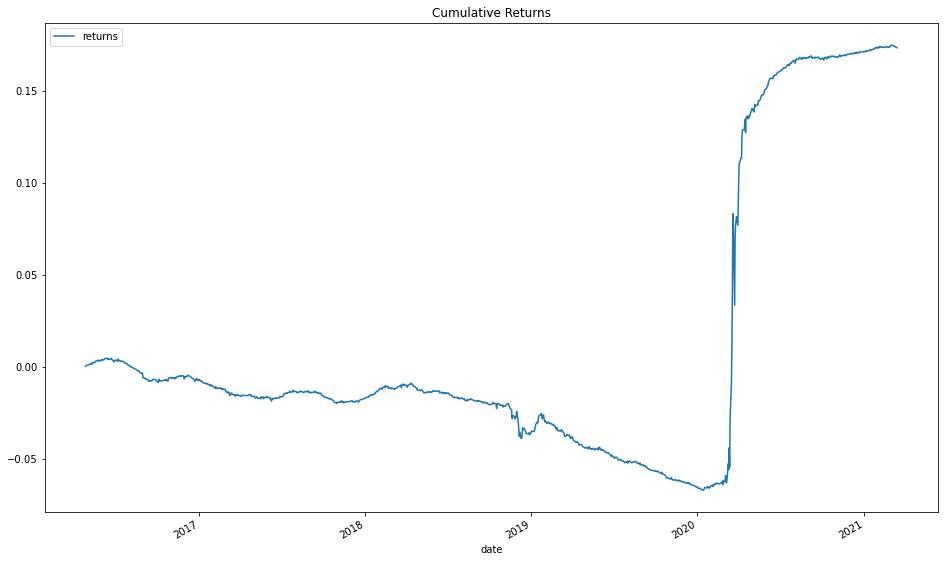

Sharpe Ratio:  0.17352283593945947
Annualized Sharpe Ratio:  2.754589624118825
Maximum Drawdown:  0.07155677346671885
Annualized Return:  3.3502087190014374
Annualized Volatility:  1.2162278873293688
Sortino Ratio:  0.7049839610939617
Annualized Sortino Ratio:  11.191273436063145
Calmar Ratio:  46.81889018598112
Omega Ratio:  1.6863539988154805
Skewness:  1.314351867248563
----------------------------------------------------------------------------
The column AFLT FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('AFRN FP Equity', 'cluster_3')


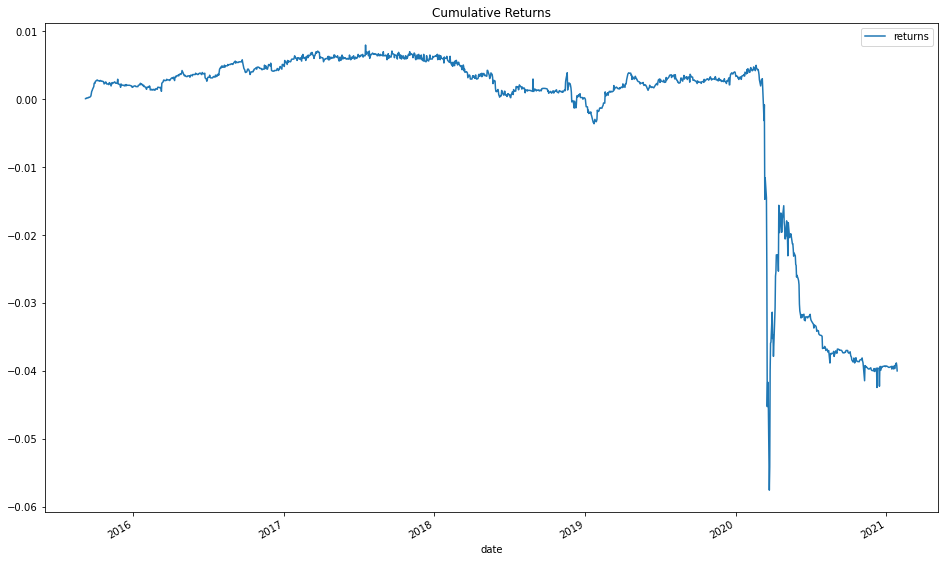

Sharpe Ratio:  -0.18729590323461515
Annualized Sharpe Ratio:  -2.9732302892400586
Maximum Drawdown:  0.0655526245888085
Annualized Return:  -0.6795942570796796
Annualized Volatility:  0.22857101232255383
Sortino Ratio:  -0.1947276068031585
Annualized Sortino Ratio:  -3.0912049259995604
Calmar Ratio:  -10.367155569171574
Omega Ratio:  0.5238475814436856
Skewness:  -1.8894984692952723
----------------------------------------------------------------------------
The column AFRN FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('CHESG SW Equity', 'cluster_4')


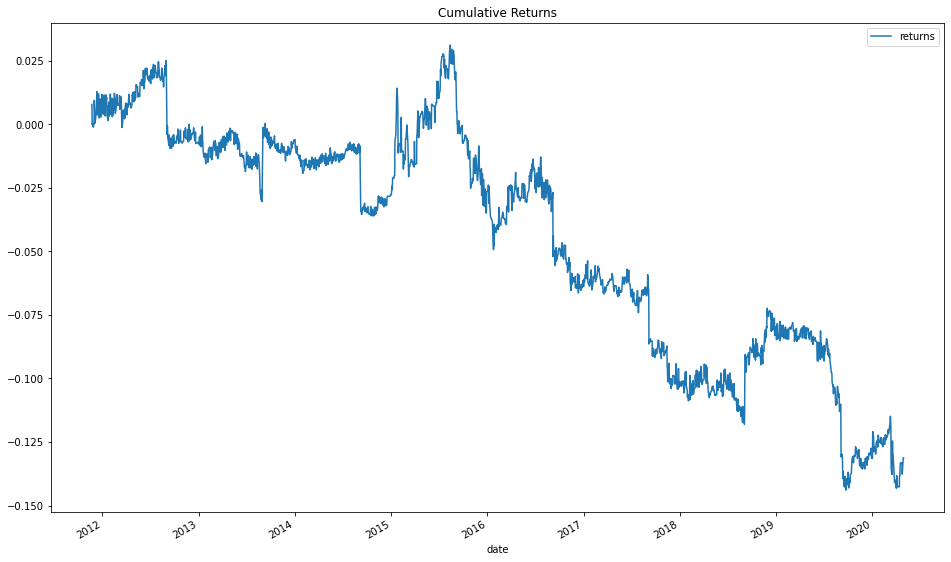

Sharpe Ratio:  -0.9807810393189167
Annualized Sharpe Ratio:  -15.569416323871895
Maximum Drawdown:  0.17513597779699852
Annualized Return:  -11.257275644228217
Annualized Volatility:  0.7230377433589427
Sortino Ratio:  -1.0575918001052778
Annualized Sortino Ratio:  -16.788749350198195
Calmar Ratio:  -64.27734487128974
Omega Ratio:  0.0374891544218421
Skewness:  -0.4465034265045772
----------------------------------------------------------------------------
The column CHESG SW Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('CRP FP Equity', 'cluster_1')


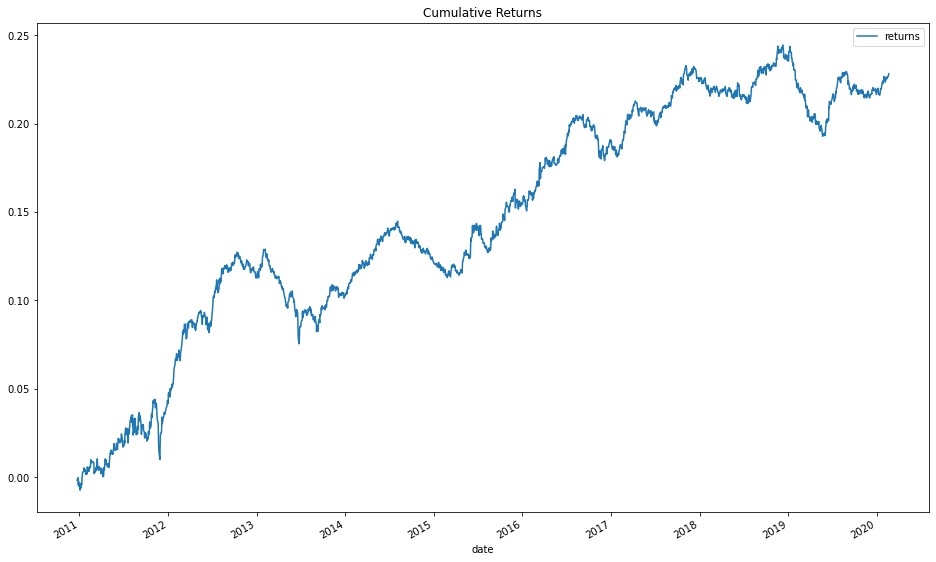

Sharpe Ratio:  2.2139833747555526
Annualized Sharpe Ratio:  35.14589649860826
Maximum Drawdown:  0.0534893640827353
Annualized Return:  36.98552582270545
Annualized Volatility:  1.0523426489965915
Sortino Ratio:  77.93118793713757
Annualized Sortino Ratio:  1237.1192559450164
Calmar Ratio:  691.455702585988
Omega Ratio:  6344.759336880275
Skewness:  -0.4897134399778823
----------------------------------------------------------------------------
The column CRP FP Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EAGG US Equity', 'cluster_2')


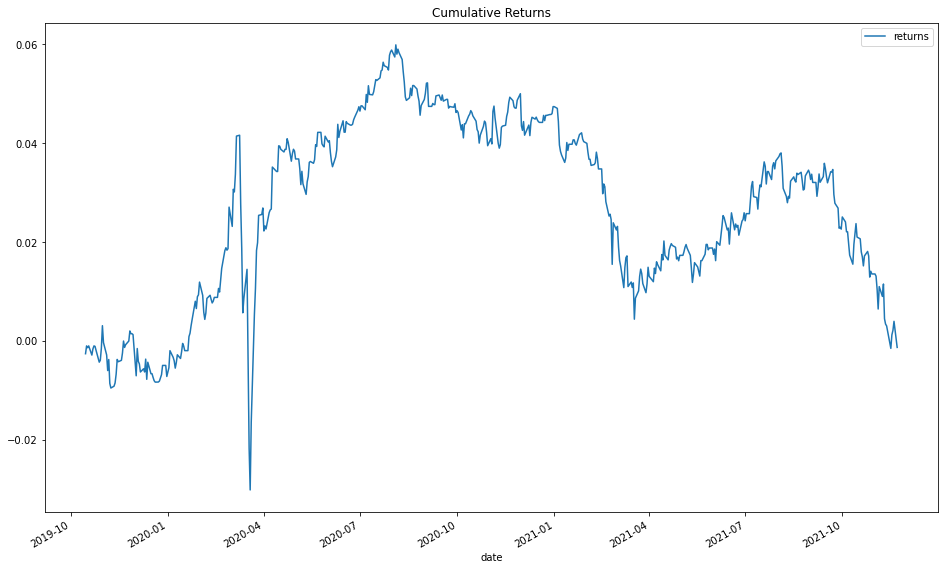

Sharpe Ratio:  1.4733068958413298
Annualized Sharpe Ratio:  23.388021907636205
Maximum Drawdown:  0.07170527887593603
Annualized Return:  6.764029009744669
Annualized Volatility:  0.2892091103923676
Sortino Ratio:  5.633222723665062
Annualized Sortino Ratio:  89.4246384399341
Calmar Ratio:  94.33097696262703
Omega Ratio:  44.245968630124004
Skewness:  -0.4029443731940388
----------------------------------------------------------------------------
The column EAGG US Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('EFRN GY Equity', 'cluster_3')


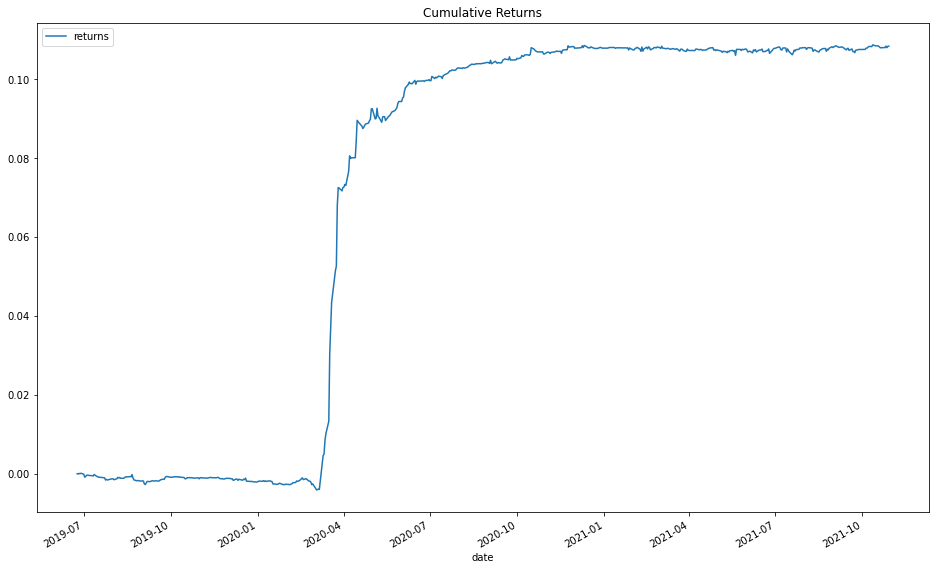

Sharpe Ratio:  1.4446559218004615
Annualized Sharpe Ratio:  22.933201794844777
Maximum Drawdown:  0.004232820044602903
Annualized Return:  17.835425469770136
Annualized Volatility:  0.7777119666639578
Sortino Ratio:  93.34330346713661
Annualized Sortino Ratio:  1481.7790051636598
Calmar Ratio:  4213.603527159479
Omega Ratio:  156.55551178691564
Skewness:  -0.7549881799548677
----------------------------------------------------------------------------
The column EFRN GY Equity does not have enough data.
----------------------------------------------------------------------------
The cluster with the highest average beta is:  ('ESGB CN Equity', 'cluster_3')


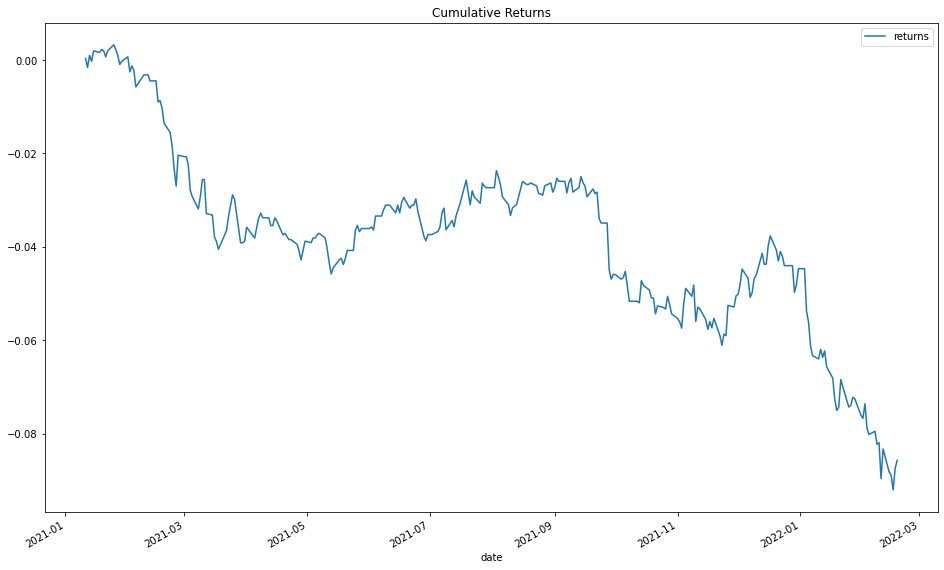

Sharpe Ratio:  -1.9772538444385952
Annualized Sharpe Ratio:  -31.387931707385494
Maximum Drawdown:  0.09524307871100246
Annualized Return:  -9.661240693718177
Annualized Volatility:  0.30780112508798774
Sortino Ratio:  -2.1429840980219423
Annualized Sortino Ratio:  -34.01881792159274
Calmar Ratio:  -101.43771940671331
Omega Ratio:  0.001689293226911074
Skewness:  -0.21854275182894456
----------------------------------------------------------------------------
The column ESGB CN Equity does not have enough data.
----------------------------------------------------------------------------


In [139]:
cumulative_return_df = pd.DataFrame(index=esg_ret_filt_mkt.index, columns=esg_ret_filt_mkt.columns)

for i in range(0, len(esg_ret_filt_mkt.columns)-20):
    try:  
        rolling_params1_1 = rolling_params1.iloc[:,i*5:i*5+5]
        trading_signals1 = generate_trading_signals(rolling_params1_1)
        strategy_returns = backtest(trading_signals1, esg_ret_filt_mkt,i)
        strategy_returns = plot_cumulative_returns(strategy_returns)
        cumulative_return_df.iloc[:,i] = strategy_returns['returns']
        print("----------------------------------------------------------------------------")
    except:
        print("----------------------------------------------------------------------------")
        print("The column " + esg_ret_filt_mkt.columns[i] + " does not have enough data.")
        print("----------------------------------------------------------------------------")

In [133]:
cumulative_return_df

Security    00878 TT Equity AEGE GY Equity AFLT FP Equity AFRN FP Equity  \
date                                                                       
2010-01-04              NaN            NaN            NaN            NaN   
2010-01-05              NaN            NaN            NaN            NaN   
2010-01-06              NaN            NaN            NaN            NaN   
2010-01-07              NaN            NaN            NaN            NaN   
2010-01-08              NaN            NaN            NaN            NaN   
...                     ...            ...            ...            ...   
2022-08-24              NaN            NaN            NaN            NaN   
2022-08-25              NaN            NaN            NaN            NaN   
2022-08-26              NaN            NaN            NaN            NaN   
2022-08-29              NaN            NaN            NaN            NaN   
2022-08-30              NaN            NaN            NaN            NaN   

Security   CHESG SW Equity CRP FP Equity EAGG US Equity EFRN GY Equity  \
date                                                                     
2010-01-04             NaN           NaN            NaN            NaN   
2010-01-05             NaN           NaN            NaN            NaN   
2010-01-06             NaN           NaN            NaN            NaN   
2010-01-07             NaN           NaN            NaN            NaN   
2010-01-08             NaN           NaN            NaN            NaN   
...                    ...           ...            ...            ...   
2022-08-24             NaN           NaN            NaN            NaN   
2022-08-25             NaN           NaN            NaN            NaN   
2022-08-26             NaN           NaN            NaN            NaN   
2022-08-29             NaN           NaN            NaN            NaN   
2022-08-30             NaN           NaN            NaN            NaN   

Security   ESGB CN Equity ESGEMC SW Equity  ... ESGUS SP Equity  \
date                                        ...                   
2010-01-04            NaN              NaN  ...             NaN   
2010-01-05            NaN              NaN  ...             NaN   
2010-01-06            NaN              NaN  ...             NaN   
2010-01-07            NaN              NaN  ...             NaN   
2010-01-08            NaN              NaN  ...             NaN   
...                   ...              ...  ...             ...   
2022-08-24            NaN              NaN  ...             NaN   
2022-08-25            NaN              NaN  ...             NaN   
2022-08-26            NaN              NaN  ...             NaN   
2022-08-29            NaN              NaN  ...             NaN   
2022-08-30            NaN              NaN  ...             NaN   

Security   EUN4 GR Equity EUN4 GY Equity EUNS GY Equity F5ESG SW Equity  \
date                                                                      
2010-01-04            NaN            NaN            NaN             NaN   
2010-01-05            NaN            NaN            NaN             NaN   
2010-01-06            NaN            NaN            NaN             NaN   
2010-01-07            NaN            NaN            NaN             NaN   
2010-01-08            NaN            NaN            NaN             NaN   
...                   ...            ...            ...             ...   
2022-08-24            NaN            NaN            NaN             NaN   
2022-08-25            NaN            NaN            NaN             NaN   
2022-08-26            NaN            NaN            NaN             NaN   
2022-08-29            NaN            NaN            NaN             NaN   
2022-08-30            NaN            NaN            NaN             NaN   

Security   IEAG NA Equity JBEM FP Equity QDVL GY Equity TAEH IM Equity  \
date                                                                     
2010-01-04            NaN            NaN            